#Preparation

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c4cd1a8e-efde-094d-af36-f0267c135095)


#Training

## Mount your Google Drive

In [ ]:
## Mount your Google Drive

#Google Drive Authentication Token
from google.colab import drive
drive.mount('drive', force_remount=True)

Mounted at drive


##Install Tacotron2

In [ ]:

%matplotlib inline
import os
import io
%cd /content/
if not os.path.isdir("/content/TTS-TT2/"):
  print("Cloning justinjohn0306/TTS-TT2")
  !git clone https://github.com/justinjohn0306/ARPAtaco2.git TTS-TT2
  %cd /content/TTS-TT2/
  !git submodule init
  !git submodule update
%cd /content/TTS-TT2/
#NVIDIA's requirements
#I believe Colab gives us PyTorch and TF by default so we don't need anything else
#Versions specified in requirements.txt have conflicts so that's why we simply get current versions
print("Downloading tacotron2 requirements")
!pip install matplotlib numpy inflect scipy Unidecode pillow
#Our requirements
#We'll need gdown to download some really cool things
!pip install git+https://github.com/wkentaro/gdown.git
import gdown
!git submodule init
!git submodule update
!pip install ffmpeg-normalize
!pip install -q unidecode tensorboardX
!apt-get -qq install sox
!apt-get install pv
!apt-get install jq
!wget https://raw.githubusercontent.com/tonikelope/megadown/master/megadown -O megadown.sh
!chmod 755 megadown.sh
#Download NVIDIA's LJSpeech model
tt2_pretrained = "https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA"
if not os.path.isfile("/content/TTS-TT2/pretrained_model"):
  print("Downloading tt2 pretrained")
  gdown.download(tt2_pretrained, "/content/TTS-TT2/pretrained_model", quiet=False)

latest_downloaded = None

import time
import logging

logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('librosa').setLevel(logging.WARNING)


import argparse
import math
from numpy import finfo

import torch
from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
from hparams import create_hparams

import random
import numpy as np

import layers
from utils import load_wav_to_torch, load_filepaths_and_text
from text import text_to_sequence
from math import e
#from tqdm import tqdm # Terminal
#from tqdm import tqdm_notebook as tqdm # Legacy Notebook TQDM
from tqdm.notebook import tqdm # Modern Notebook TQDM
from distutils.dir_util import copy_tree
import matplotlib.pylab as plt

def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

def create_mels():
    print("Generating Mels")
    stft = layers.TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                hparams.mel_fmax)
    def save_mel(filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename,
                sampling_rate, stft.sampling_rate))
        audio_norm = audio / hparams.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    import glob
    wavs = glob.glob('wavs/*.wav')
    for i in tqdm(wavs):
        save_mel(i)


def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= n_gpus
    return rt


def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")

    # Set cuda device so everything is done on the right GPU.
    torch.cuda.set_device(rank % torch.cuda.device_count())

    # Initialize distributed communication
    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")


def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn


def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger


def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model


def warm_start_model(checkpoint_path, model, ignore_layers):
    assert os.path.isfile(checkpoint_path)
    print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = checkpoint_dict['state_dict']
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model


def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration


def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    import random
    if True:
        print("Saving model and optimizer state at iteration {} to {}".format(
            iteration, filepath))
        try:
            torch.save({'iteration': iteration,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'learning_rate': learning_rate}, filepath)
        except KeyboardInterrupt:
            print("interrupt received while saving, waiting for save to complete.")
            torch.save({'iteration': iteration,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'learning_rate': learning_rate}, filepath)
        print("Model Saved")

def plot_alignment(alignment, info=None):
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(int(alignment_graph_width/100), int(alignment_graph_height/100)))
    im = ax.imshow(alignment, cmap='inferno', aspect='auto', origin='lower',
                   interpolation='none')
    ax.autoscale(enable=True, axis="y", tight=True)
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += '\n\n' + info
    plt.xlabel(xlabel)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    fig.canvas.draw()
    plt.show()

def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_eposh, learning_rate):
    """Handles all the validation scoring and printing"""
    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    if rank == 0:
        print("Epoch: {} Validation loss {}: {:9f}  Time: {:.1f}m LR: {:.6f}".format(epoch, iteration, val_loss,(time.perf_counter()-start_eposh)/60, learning_rate))
        logger.log_validation(val_loss, model, y, y_pred, iteration)
        if hparams.show_alignments:
            %matplotlib inline
            _, mel_outputs, gate_outputs, alignments = y_pred
            idx = random.randint(0, alignments.size(0) - 1)
            plot_alignment(alignments[idx].data.cpu().numpy().T)

def train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus,
          rank, group_name, hparams, log_directory2, save_interval, backup_interval):
    """Training and validation logging results to tensorboard and stdout

    Params
    ------
    output_directory (string): directory to save checkpoints
    log_directory (string) directory to save tensorboard logs
    checkpoint_path(string): checkpoint path
    n_gpus (int): number of gpus
    rank (int): rank of current gpu
    hparams (object): comma separated list of "name=value" pairs.
    """
    if hparams.distributed_run:
        init_distributed(hparams, n_gpus, rank, group_name)

    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = load_model(hparams)
    learning_rate = hparams.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=hparams.weight_decay)

    if hparams.fp16_run:
        from apex import amp
        model, optimizer = amp.initialize(
            model, optimizer, opt_level='O2')

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    criterion = Tacotron2Loss()

    logger = prepare_directories_and_logger(
        output_directory, log_directory, rank)

    train_loader, valset, collate_fn = prepare_dataloaders(hparams)

    # Load checkpoint if one exists
    iteration = 0
    epoch_offset = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        if warm_start:
            model = warm_start_model(
                checkpoint_path, model, hparams.ignore_layers)
        else:
            model, optimizer, _learning_rate, iteration = load_checkpoint(
                checkpoint_path, model, optimizer)
            if hparams.use_saved_learning_rate:
                learning_rate = _learning_rate
            iteration += 1  # next iteration is iteration + 1
            epoch_offset = max(0, int(iteration / len(train_loader)))
    else:
      os.path.isfile("/content/TTS-TT2/pretrained_model")
      %cd /dev/null
      !/content/TTS-TT2/megadown.sh https://mega.nz/#!WXY3RILA!KyoGHtfB_sdhmLFoykG2lKWhh0GFdwMkk7OwAjpQHRo --o pretrained_model
      %cd /content/TTS-TT2
      model = warm_start_model("/content/TTS-TT2/pretrained_model", model, hparams.ignore_layers)
      # download LJSpeech pretrained model if no checkpoint already exists

    start_eposh = time.perf_counter()
    learning_rate = 0.0
    model.train()
    is_overflow = False
    # ================ MAIN TRAINNIG LOOP! ===================
    for epoch in tqdm(range(epoch_offset, hparams.epochs)):
        print("\nStarting Epoch: {} Iteration: {}".format(epoch, iteration))
        start_eposh = time.perf_counter() # eposh is russian, not a typo
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            start = time.perf_counter()
            if iteration < hparams.decay_start: learning_rate = hparams.A_
            else: iteration_adjusted = iteration - hparams.decay_start; learning_rate = (hparams.A_*(e**(-iteration_adjusted/hparams.B_))) + hparams.C_
            learning_rate = max(hparams.min_learning_rate, learning_rate) # output the largest number
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

            model.zero_grad()
            x, y = model.parse_batch(batch)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            if hparams.distributed_run:
                reduced_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_loss = loss.item()
            if hparams.fp16_run:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if hparams.fp16_run:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    amp.master_params(optimizer), hparams.grad_clip_thresh)
                is_overflow = math.isnan(grad_norm)
            else:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)

            optimizer.step()

            if not is_overflow and rank == 0:
                duration = time.perf_counter() - start
                logger.log_training(
                    reduced_loss, grad_norm, learning_rate, duration, iteration)
                #print("Batch {} loss {:.6f} Grad Norm {:.6f} Time {:.6f}".format(iteration, reduced_loss, grad_norm, duration), end='\r', flush=True)

            iteration += 1
        validate(model, criterion, valset, iteration,
                 hparams.batch_size, n_gpus, collate_fn, logger,
                 hparams.distributed_run, rank, epoch, start_eposh, learning_rate)
        if (epoch+1) % save_interval == 0 or (epoch+1) == hparams.epochs: # not sure if the latter is necessary
            save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path)
        if backup_interval > 0 and (epoch+1) % backup_interval == 0:
            save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path + "_epoch_%s" % (epoch+1))
        if log_directory2 != None:
            copy_tree(log_directory, log_directory2)
def check_dataset(hparams):
    from utils import load_wav_to_torch, load_filepaths_and_text
    import os
    import numpy as np
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            if (not os.path.exists(file[0])):
                print("|".join(file), "\n[WARNING] does not exist.")
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files) # get split lines from training_files text file.
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files) # get split lines from validation_files text file.
    check_arr(audiopaths_and_text)
    print("Finished Checking")

warm_start=False#sorry bout that
n_gpus=1
rank=0
group_name=None

# ---- DEFAULT PARAMETERS DEFINED HERE ----
hparams = create_hparams()
model_filename = 'current_model'
hparams.training_files = "filelists/clipper_train_filelist.txt"
hparams.validation_files = "filelists/clipper_val_filelist.txt"
#hparams.use_mmi=True,          # not used in this notebook
#hparams.use_gaf=True,          # not used in this notebook
#hparams.max_gaf=0.5,           # not used in this notebook
#hparams.drop_frame_rate = 0.2  # not used in this notebook
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000
hparams.A_ = 5e-4
hparams.B_ = 8000
hparams.C_ = 0
hparams.min_learning_rate = 1e-5
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.batch_size = 32
hparams.load_mel_from_disk = True
hparams.ignore_layers = []
hparams.epochs = 10000
torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark
output_directory = '/content/drive/My Drive/colab/outdir' # Location to save Checkpoints
log_directory = '/content/TTS-TT2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/My Drive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

# ---- Replace .wav with .npy in filelists ----
!sed -i -- 's,.wav|,.npy|,g' filelists/*.txt
!sed -i -- 's,.wav|,.npy|,g' {hparams.training_files}
!sed -i -- 's,.wav|,.npy|,g' {hparams.validation_files}
# ---- Replace .wav with .npy in filelists ----

%cd /content/TTS-TT2

data_path = 'wavs'
!mkdir {data_path}

/content
Cloning justinjohn0306/TTS-TT2
Cloning into 'TTS-TT2'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 89 (delta 2), reused 0 (delta 0), pack-reused 80
Unpacking objects: 100% (89/89), 7.11 MiB | 5.38 MiB/s, done.
/content/TTS-TT2
/content/TTS-TT2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 11.3 MB/s eta 0:00:00
  Cloning https://github.com/wkentaro/gdown.git to /tmp/pip-req-build-yk2s62f8
  Running command git clone --filter=blob:none --quiet https://github.com/wkentaro/gdown.git /tmp/pip-req-build-yk2s62f8
  Resolved https://github.com/wkentaro/gdown.git to commit 5c7507f02718048899b85d4010a6ed93316cbf27
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gdown: filename=gdown-4.7.1-py3-none-any.whl siz

Downloading...
From (original): https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA
From (redirected): https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA&confirm=t&uuid=8f93c12d-2fba-478b-b945-e7c7dc4b5eb6
To: /content/TTS-TT2/pretrained_model
100%|██████████| 113M/113M [00:02<00:00, 52.1MB/s]
/content/TTS-TT2/text/__init__.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'
/content/TTS-TT2/text/__init__.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return s in _symbol_to_id and s is not '_' and s is not '~'


sed: can't read filelists/clipper_train_filelist.txt: No such file or directory
sed: can't read filelists/clipper_val_filelist.txt: No such file or directory
/content/TTS-TT2


## 3. Load dataset

In [ ]:

#@markdown ---
#@markdown #### The audios can be compressed in a **ZIP** file (recommended) or loose.
#@markdown #### You can also manually upload the ZIP/folder and enter the path in the field below, or import your audios from Drive by entering the path in the template "/content/drive/My Drive/your_file". If you want to **upload in the cell itself, leave the field empty**.
#@markdown ---
#@markdown #### Enable audio processing?
#@markdown Remember that they must be in a compatible format, i.e., sample rate <font color="orange">**22050, 16 bit, mono**</font>. If you do not have the audios in this format, check this box to make the conversion, apart from normalization and silence removal.
audio_processing = True #@param {type:"boolean"}
drive_path = "/content/drive/MyDrive/wavs.zip" #@param {type: "string"}

from google.colab import files
import zipfile
import os
import wave
import shutil
import datetime

if os.listdir('/content/TTS-TT2/wavs/'):
  !rm /content/TTS-TT2/wavs/*

with open('/content/audios.sh', 'w') as rsh:
    rsh.write('''\
for file in /content/TTS-TT2/wavs/*.wav
do
    ffmpeg -y -i "$file" -ar 22050 /content/tempwav/srtmp.wav -loglevel error
    ffmpeg -y -i /content/tempwav/srtmp.wav -c copy -fflags +bitexact -flags:v +bitexact -flags:a +bitexact -ar 22050 /content/tempwav/poop.wav -loglevel error
    rm "$file"
    mv /content/tempwav/poop.wav "$file"
    rm /content/tempwav/*
done
''')

%cd /content/TTS-TT2/wavs

drive_path = drive_path.strip()

if drive_path:
  if os.path.exists(drive_path):
    print(f"\n\033[34m\033[1mAudio imported from Drive.\n\033[90m")
    if zipfile.is_zipfile(drive_path):
      !unzip -q -j "$drive_path" -d /content/TTS-TT2/wavs

    else:
      fp = drive_path + "/."
      !cp -a "$fp" "/content/TTS-TT2/wavs"
  else:
    print(f"\n\033[33m\033[1m[NOTICE] The path {drive_path} is not found, check for errors and try again.")
    print(f"\n\033[34m\033[1mUpload your dataset(audios)...")
    uploaded = files.upload()
else:
  print(f"\n\033[34m\033[1mUpload your dataset(audios)...")
  uploaded = files.upload()

  for fn in uploaded.keys():
    if zipfile.is_zipfile(fn):
      !unzip -q -j "$fn" -d /content/TTS-TT2/wavs
      !rm "$fn"

if os.path.exists("/content/TTS-TT2/wavs/wavs"):
    for file in os.listdir("/content/TTS-TT2/wavs/wavs"):
      !mv /content/TTS-TT2/wavs/wavs/"$file"  /content/TTS-TT2/wavs/"$file"
!rm /content/TTS-TT2/wavs/list.txt
if audio_processing:
  print(f"\n\033[37mMetadata removal and audio verification...")
  !mkdir /content/tempwav
  !bash /content/audios.sh

totalduration = 0
for file_name in [x for x in os.listdir() if os.path.isfile(x)]:
    with wave.open(file_name, "rb") as wave_file:
        frames = wave_file.getnframes()
        rate = wave_file.getframerate()
        duration = frames / float(rate)
        totalduration += duration

        if duration >= 12:
          print(f"\n\033[33m\033[1m[NOTICE] {file_name} is longer than 12 seconds. Lack of RAM can"
                " occur in a large batch size!")

wav_count = len(os.listdir("/content/TTS-TT2/wavs"))
print(f"\n{wav_count} processed audios. total duration: {str(datetime.timedelta(seconds=round(totalduration, 0)))}\n")

#shutil.make_archive("/content/processedwavs", 'zip', '/content/TTS-TT2/wavs')
#files.download('/content/processedwavs.zip')

print("\n\033[32m\033[1mAll set, please proceed.")

/content/TTS-TT2/wavs

Audio imported from Drive.

rm: cannot remove '/content/TTS-TT2/wavs/list.txt': No such file or directory

Metadata removal and audio verification...

[NOTICE] 16.wav is longer than 12 seconds. Lack of RAM can occur in a large batch size!

[NOTICE] 19.wav is longer than 12 seconds. Lack of RAM can occur in a large batch size!

[NOTICE] 13.wav is longer than 12 seconds. Lack of RAM can occur in a large batch size!

[NOTICE] 4.wav is longer than 12 seconds. Lack of RAM can occur in a large batch size!

[NOTICE] 37.wav is longer than 12 seconds. Lack of RAM can occur in a large batch size!

[NOTICE] 17.wav is longer than 12 seconds. Lack of RAM can occur in a large batch size!

[NOTICE] 14.wav is longer than 12 seconds. Lack of RAM can occur in a large batch size!

[NOTICE] 15.wav is longer than 12 seconds. Lack of RAM can occur in a large batch size!

[NOTICE] 3.wav is longer than 12 seconds. Lack of RAM can occur in a large batch size!

[NOTICE] 24.wav is longer t

In [ ]:
#@markdown ## <font color="pink"> **4. Upload the transcript.** 📝
#@markdown The transcript must be a ``.TXT`` file formatted in <font color="red" size="+3"> ``UTF-8 without BOM.``

from google.colab import files
import os

%cd /content/TTS-TT2/filelists/
!rm /content/TTS-TT2/filelists/list.txt

print("\n\033[34m\033[1mUpload your transcript(list)...")
listfn, length = files.upload().popitem()

if listfn != "list.txt":
  !mv "$listfn" list.txt


with open('list.txt', 'r') as f:
    lines = f.readlines()


new_lines = []
for line in lines:
    audio_file_path = '/content/TTS-TT2/' + line.split('|')[0]

    if os.path.exists(audio_file_path):
        new_lines.append(line)


with open('list.txt', 'w') as f:
    f.writelines(new_lines)

%cd /content/TTS-TT2/
print("\n\033[32m\033[1mAll set, please proceed.")

/content/TTS-TT2/filelists

Upload your transcript(list)...


Saving list.txt to list.txt
/content/TTS-TT2

All set, please proceed.


## 5. Configure the model parameters

In [ ]:


#@markdown ---

#@markdown #### Your desired model name:

model_filename = 'modijii-40' #@param {type: "string"}

#@markdown #### Upload your transcription / text to TTS-TT2/filelists and right click -> copy path:
Training_file = "filelists/list.txt" #@param {type: "string"}
hparams.training_files = Training_file
hparams.validation_files = Training_file




# hparams to Tune
#hparams.use_mmi=True,          # not used in this notebook
#hparams.use_gaf=True,          # not used in this notebook
#hparams.max_gaf=0.5,           # not used in this notebook
#hparams.drop_frame_rate = 0.2  # not used in this notebook
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1

# Learning Rate             # https://www.desmos.com/calculator/ptgcz4vzsw / http://boards.4channel.org/mlp/thread/34778298#p34789030
hparams.decay_start = 15000         # wait till decay_start to start decaying learning rate

#@markdown #### Lower learning rates will take more time but will lead to more accurate results:
# Start/Max Learning Rate
hparams.A_ = 3e-2 #@param ["3e-6", "1e-5", "1e-4", "5e-4", "1e-3"] {type:"raw", allow-input: true}
hparams.B_ = 8000                   # Decay Rate
hparams.C_ = 0                      # Shift learning rate equation by this value
hparams.min_learning_rate = 1e-5    # Min Learning Rate

# Quality of Life
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000

#@markdown #### Your batch size, lower if you don't have enough ram:

hparams.batch_size =  8#@param {type: "integer"}
hparams.load_mel_from_disk = True
hparams.ignore_layers = [] # Layers to reset (None by default, other than foreign languages this param can be ignored)
use_cmudict = True #@param {type:"boolean"}
#@markdown #### Your total epochs to train to. Not recommended to change:

##@markdown #### Amount of epochs before stopping, preferably a very high amount to not stop.
hparams.epochs =  250#@param {type: "integer"}

torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark

#@markdown #### Where to save your model when training:
output_directory = '/content/drive/MyDrive/colab/outdir' #@param {type: "string"}
log_directory = '/content/TTS-TT2/logs' # Location to save Log files locally
log_directory2 = '/content/drive/My Drive/colab/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

##@markdown #### Train the model from scratch? (If yes, then uncheck the box below):
#warm_start=True #@param {type:"boolean"}


#@markdown ---
hparams.text_cleaners=["english_cleaners"] + (["cmudict_cleaners"] if use_cmudict is True else [])


#@markdown Note:-

#@markdown - The learning_rate value is ordered from smallest to largest, top to bottom.

#@markdown - The smaller the "learning rates" value is, the longer it will take to train the model, but the more accurate the results will be.

#@markdown ___

#@markdown Todo:-
#@markdown - Disable warm_start
#@markdown - Add tensorboard training monitor

#@markdown ___


## 6. Convert the .WAV files to Mel spectrograms and check the files.

In [ ]:


if generate_mels:
    create_mels()

print("Checking for missing files")
# ---- Replace .wav with .npy in filelists ----
!sed -i -- 's,.wav|,.npy|,g' {hparams.training_files}; sed -i -- 's,.wav|,.npy|,g' {hparams.validation_files}

check_dataset(hparams)

Generating Mels


  0%|          | 0/40 [00:00<?, ?it/s]

Checking for missing files
Checking Training Files
Checking Validation Files
Finished Checking


## 7. Check the working cmudict patch

In [ ]:

%cd /content/TTS-TT2/
import text
print(text.sequence_to_text(text.text_to_sequence("Hello India this is Modi in Australia", ["cmudict_cleaners", "english_cleaners"])))

/content/TTS-TT2
{HH AH0 L OW1} {IH1 N D IY0 AH0} {DH IH1 S} {IH1 Z} {M OW1 D IY0} {IH0 N} {AO0 S T R EY1 L Y AH0}


## 8. Begin training8.

FP16 Run: False
Dynamic Loss Scaling: True
Distributed Run: False
cuDNN Enabled: True
cuDNN Benchmark: False
[Errno 20] Not a directory: '/dev/null'
/content/TTS-TT2

Reading link metadata...


/content/TTS-TT2
Warm starting model from checkpoint '/content/TTS-TT2/pretrained_model'


  0%|          | 0/250 [00:00<?, ?it/s]


Starting Epoch: 0 Iteration: 0


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 Validation loss 5: 23.252952  Time: 0.8m LR: 0.030000


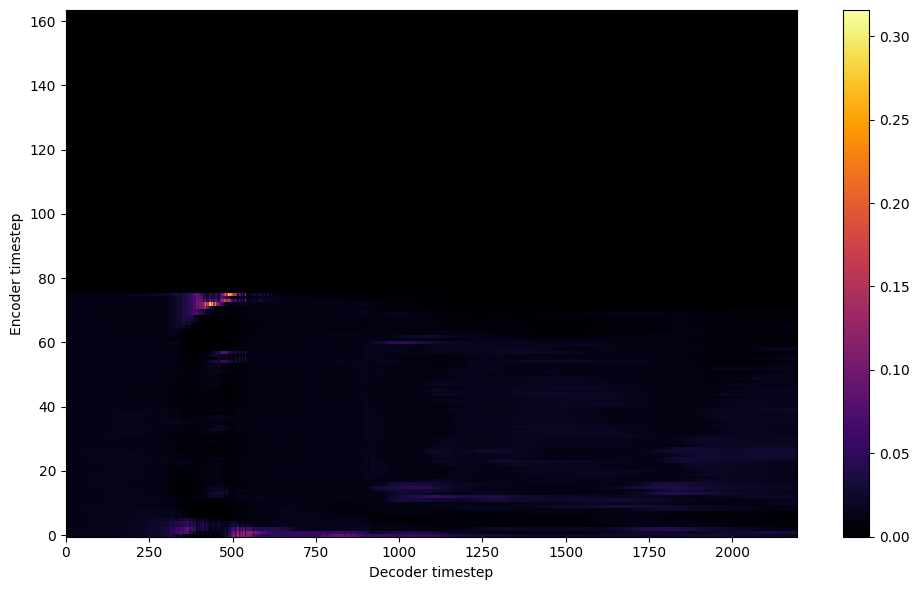


Starting Epoch: 1 Iteration: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 Validation loss 10: 15.702322  Time: 0.7m LR: 0.030000


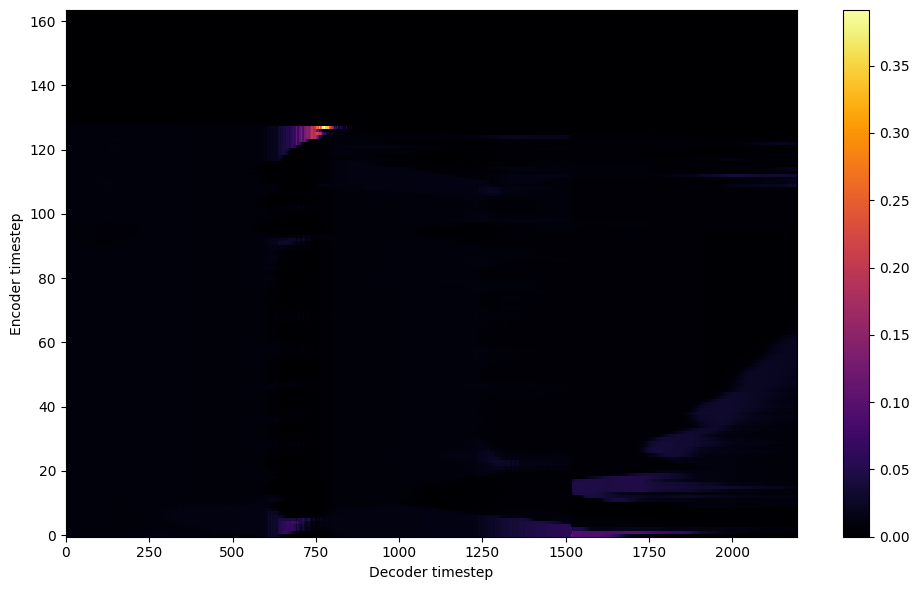


Starting Epoch: 2 Iteration: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2 Validation loss 15: 10.583035  Time: 0.7m LR: 0.030000


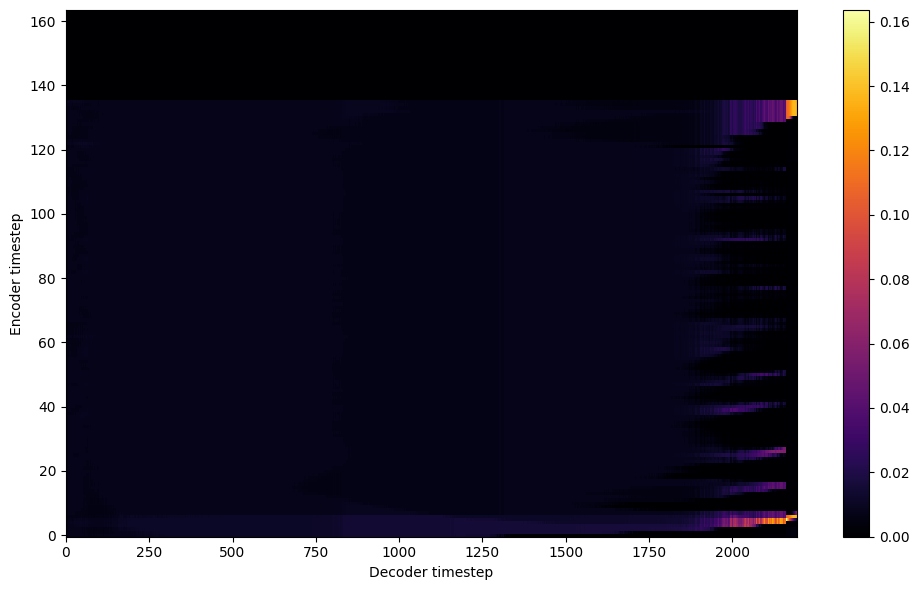


Starting Epoch: 3 Iteration: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3 Validation loss 20: 10.004094  Time: 0.7m LR: 0.030000


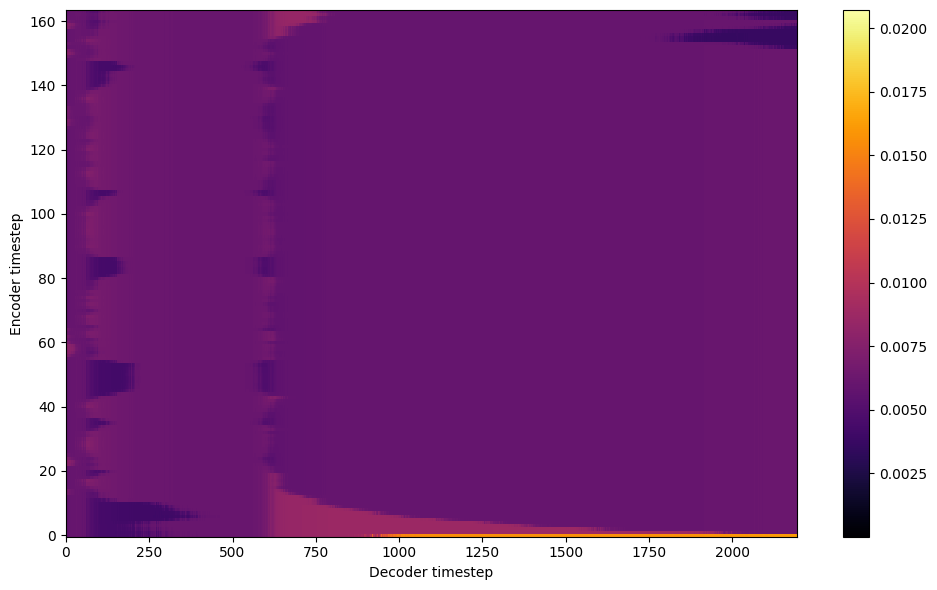


Starting Epoch: 4 Iteration: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 4 Validation loss 25: 10.905314  Time: 0.8m LR: 0.030000


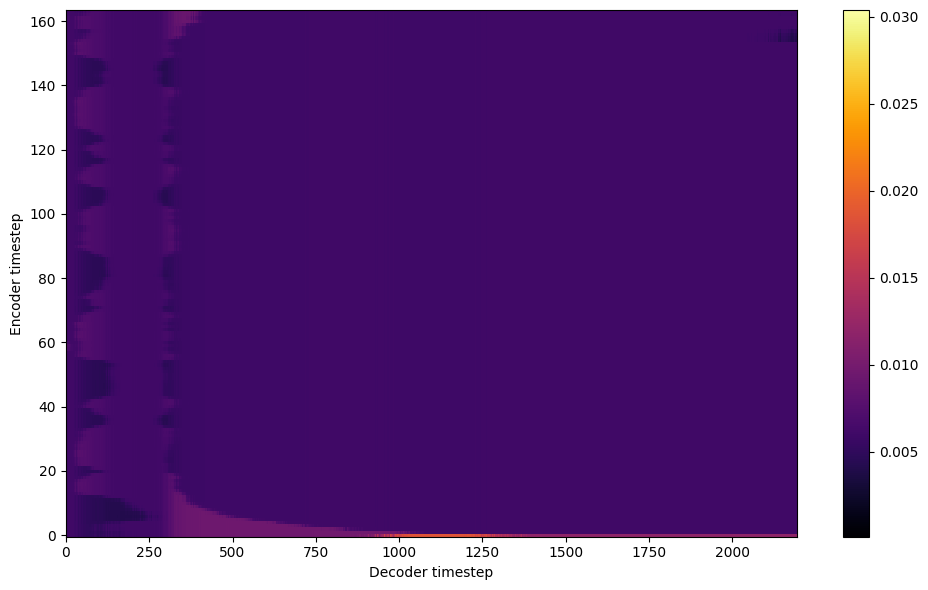


Starting Epoch: 5 Iteration: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 5 Validation loss 30: 10.423396  Time: 0.7m LR: 0.030000


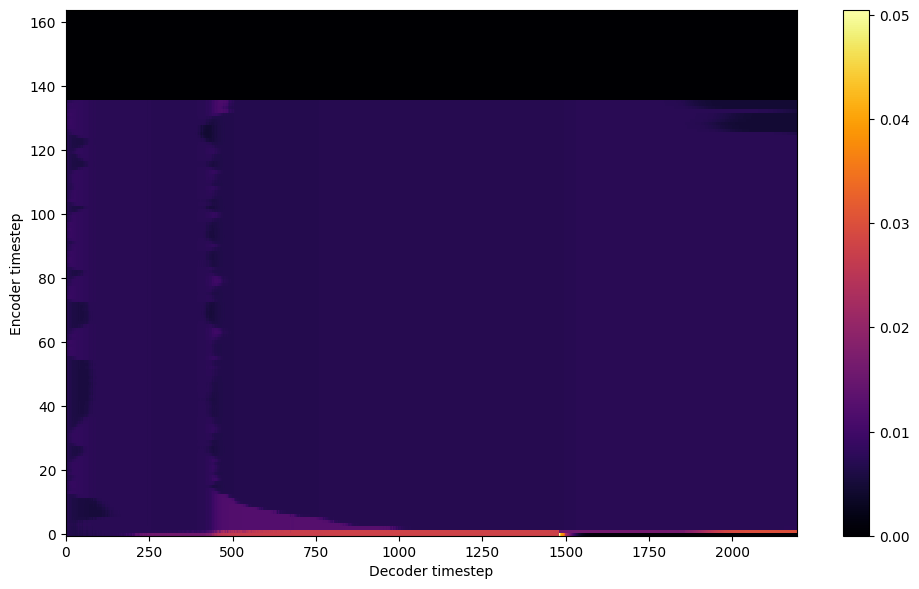


Starting Epoch: 6 Iteration: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 6 Validation loss 35:  9.034308  Time: 0.8m LR: 0.030000


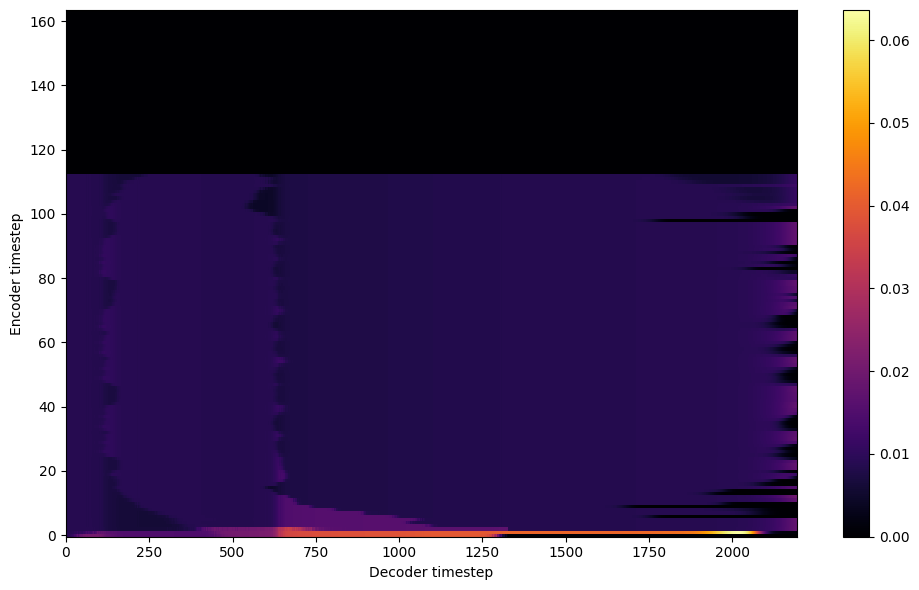


Starting Epoch: 7 Iteration: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 7 Validation loss 40:  9.114668  Time: 0.7m LR: 0.030000


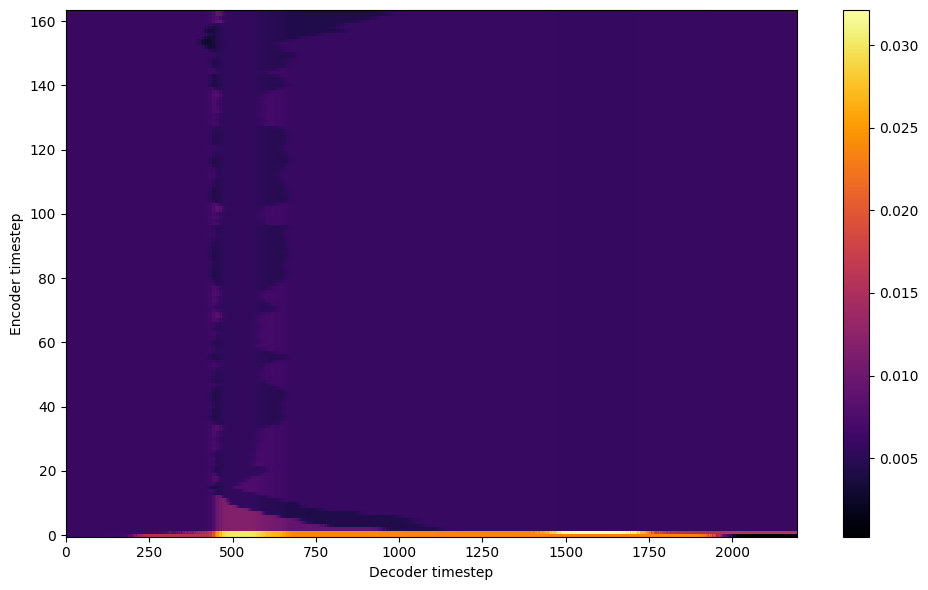


Starting Epoch: 8 Iteration: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 8 Validation loss 45: 11.745822  Time: 0.8m LR: 0.030000


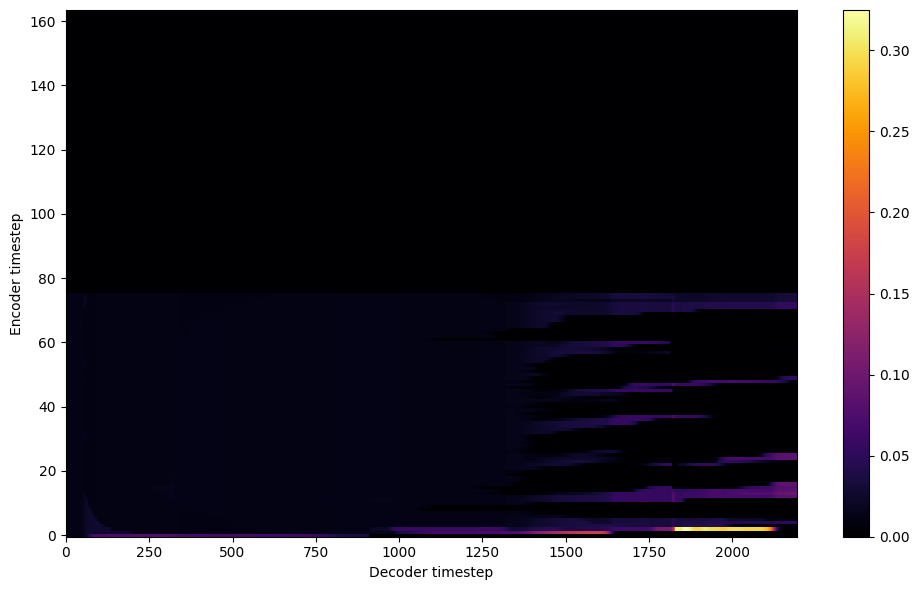


Starting Epoch: 9 Iteration: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 9 Validation loss 50:  9.124668  Time: 0.7m LR: 0.030000


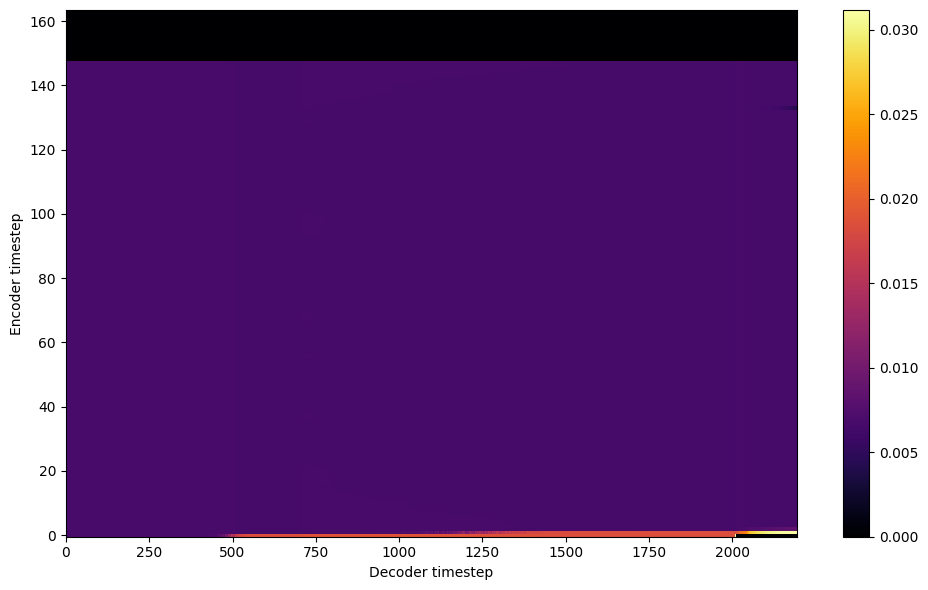

Saving model and optimizer state at iteration 50 to /content/drive/MyDrive/colab/outdir/modijii-40
Model Saved

Starting Epoch: 10 Iteration: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 10 Validation loss 55:  8.794196  Time: 0.8m LR: 0.030000


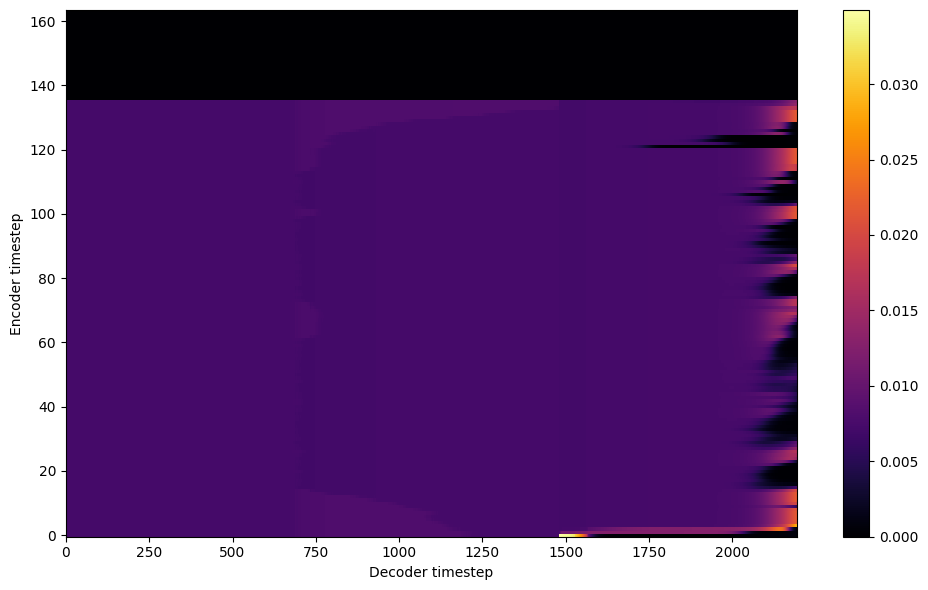


Starting Epoch: 11 Iteration: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 11 Validation loss 60:  9.592462  Time: 0.8m LR: 0.030000


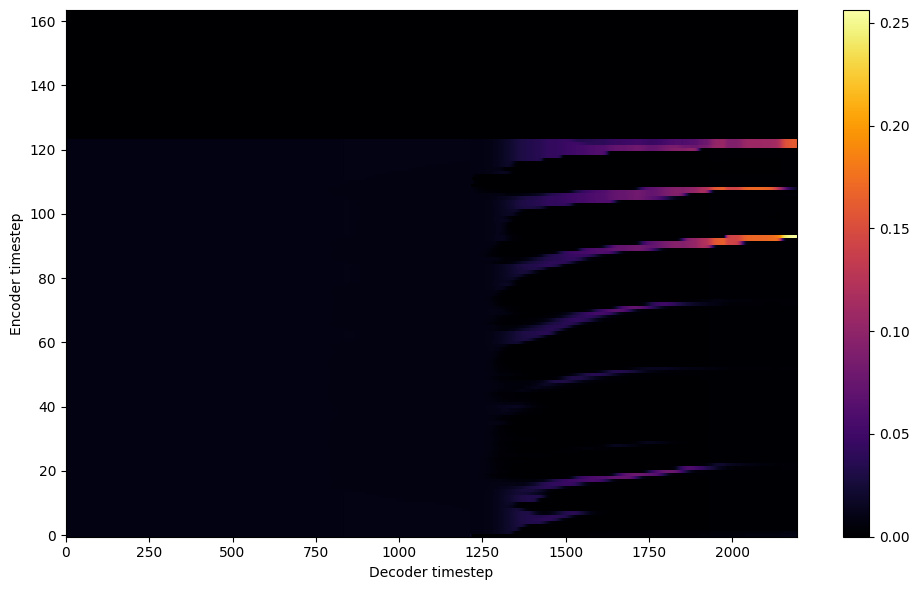


Starting Epoch: 12 Iteration: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 12 Validation loss 65:  9.274715  Time: 0.8m LR: 0.030000


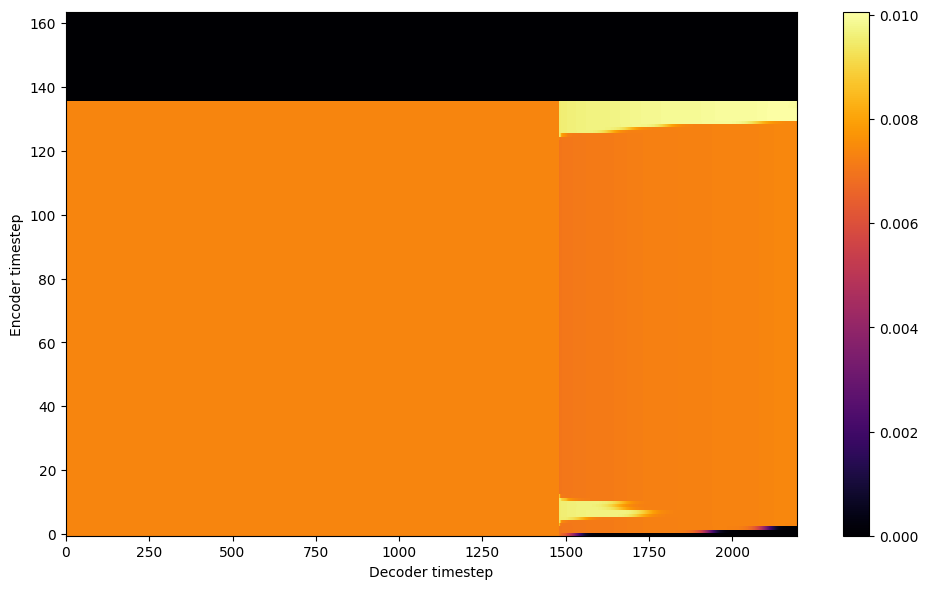


Starting Epoch: 13 Iteration: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 13 Validation loss 70:  8.901305  Time: 0.7m LR: 0.030000


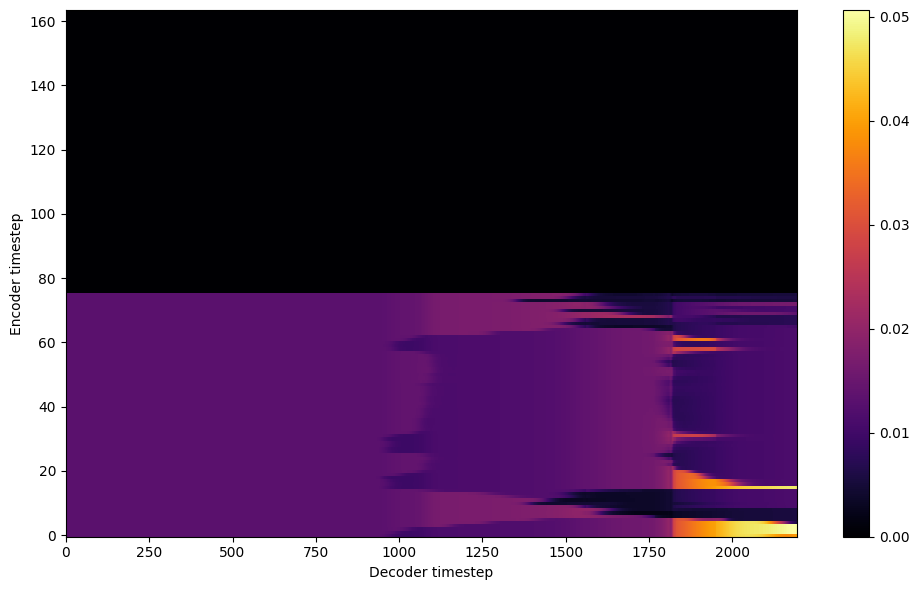


Starting Epoch: 14 Iteration: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 14 Validation loss 75:  8.707371  Time: 0.8m LR: 0.030000


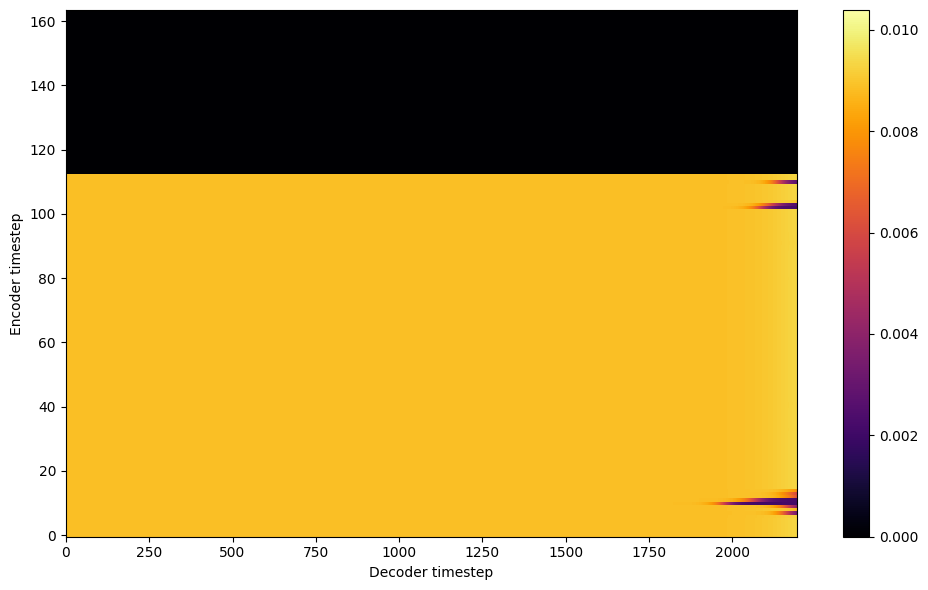


Starting Epoch: 15 Iteration: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 15 Validation loss 80: 10.077324  Time: 0.7m LR: 0.030000


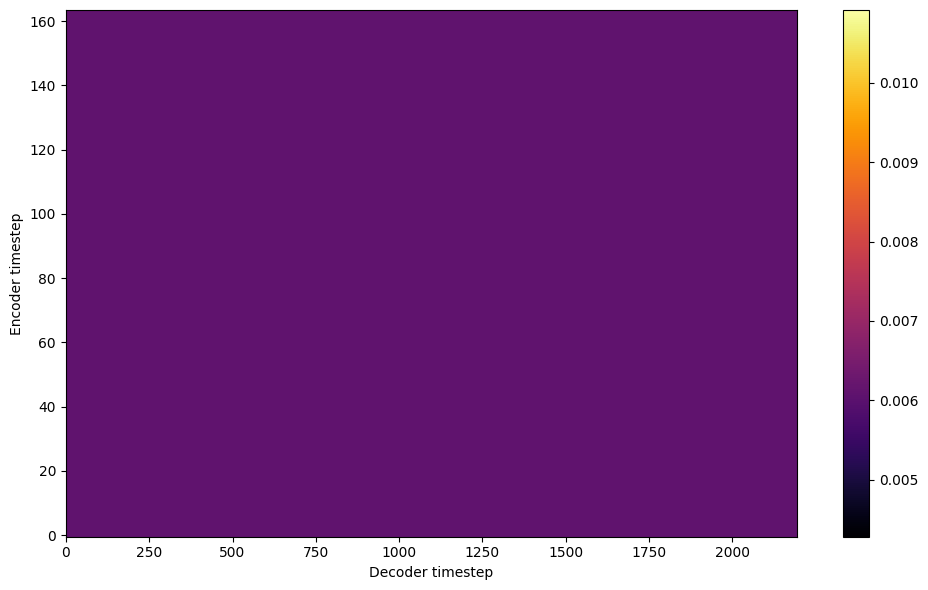


Starting Epoch: 16 Iteration: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 16 Validation loss 85:  9.063663  Time: 0.8m LR: 0.030000


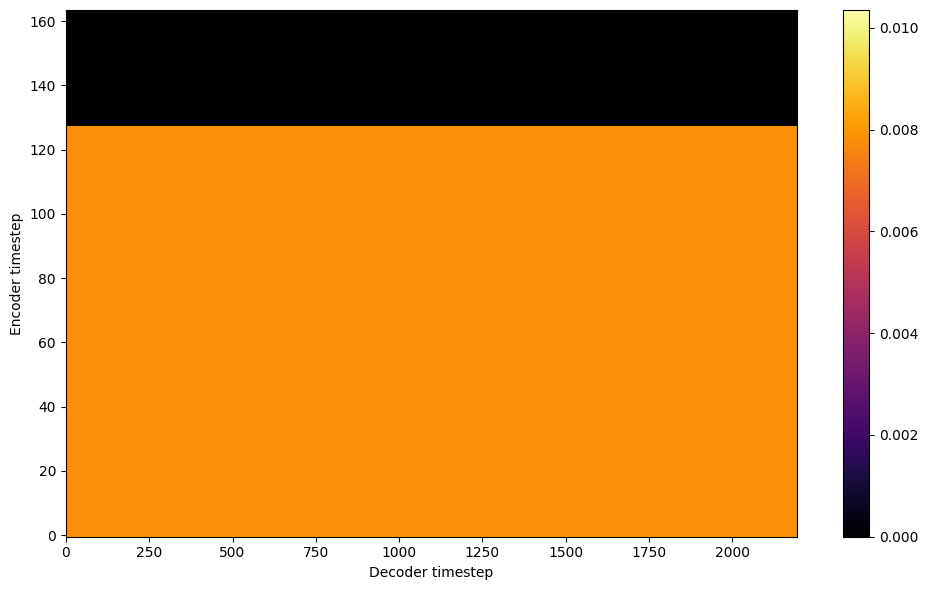


Starting Epoch: 17 Iteration: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 17 Validation loss 90:  8.607544  Time: 0.7m LR: 0.030000


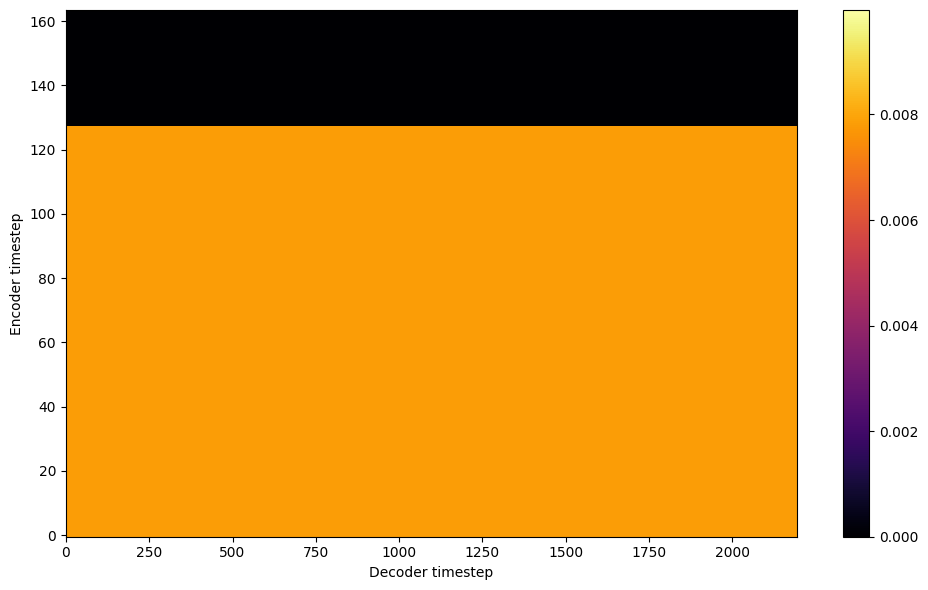


Starting Epoch: 18 Iteration: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 18 Validation loss 95: 10.307417  Time: 0.7m LR: 0.030000


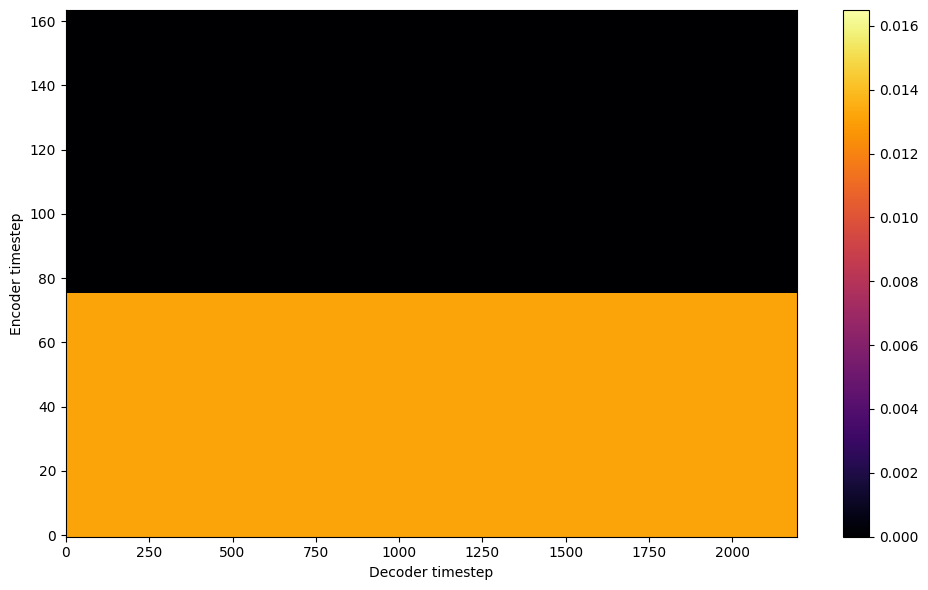


Starting Epoch: 19 Iteration: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 19 Validation loss 100:  8.811838  Time: 0.7m LR: 0.030000


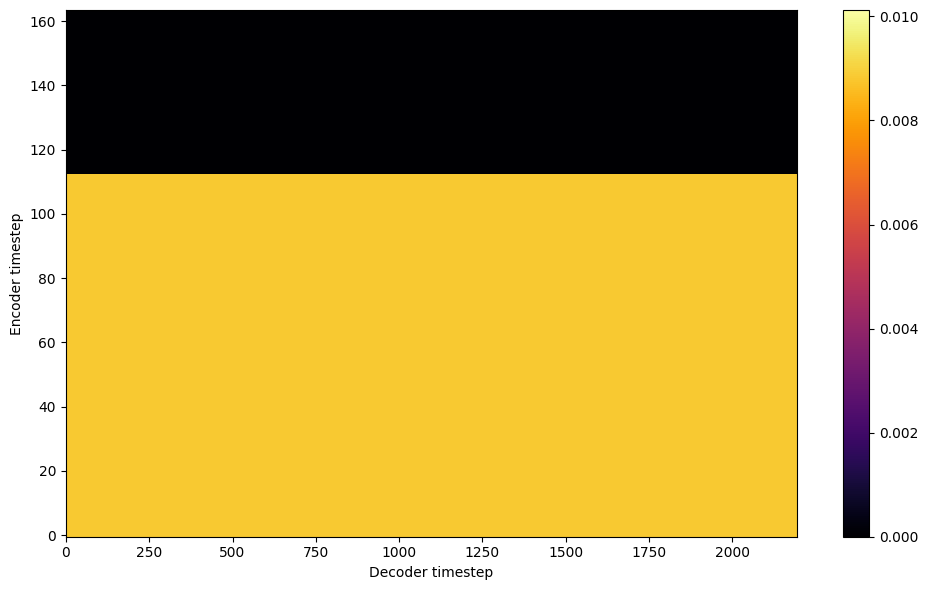

Saving model and optimizer state at iteration 100 to /content/drive/MyDrive/colab/outdir/modijii-40
Model Saved

Starting Epoch: 20 Iteration: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 20 Validation loss 105:  8.612839  Time: 0.8m LR: 0.030000


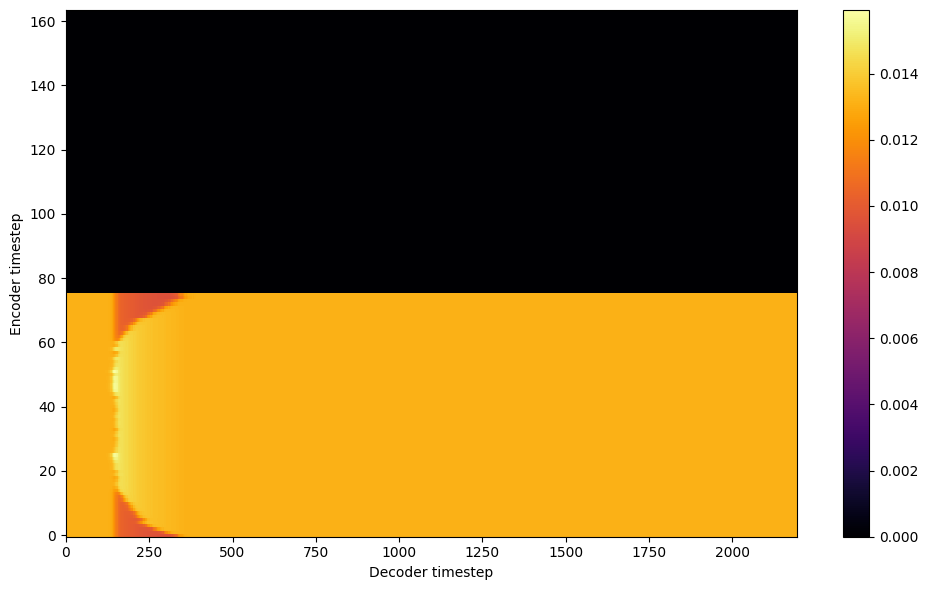


Starting Epoch: 21 Iteration: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 21 Validation loss 110: 10.305767  Time: 0.7m LR: 0.030000


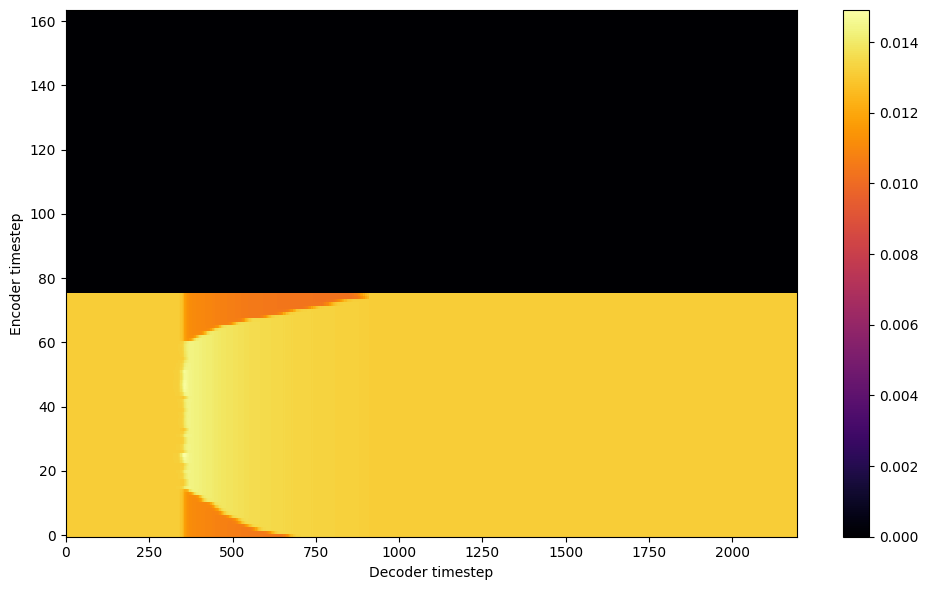


Starting Epoch: 22 Iteration: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 22 Validation loss 115:  8.744493  Time: 0.8m LR: 0.030000


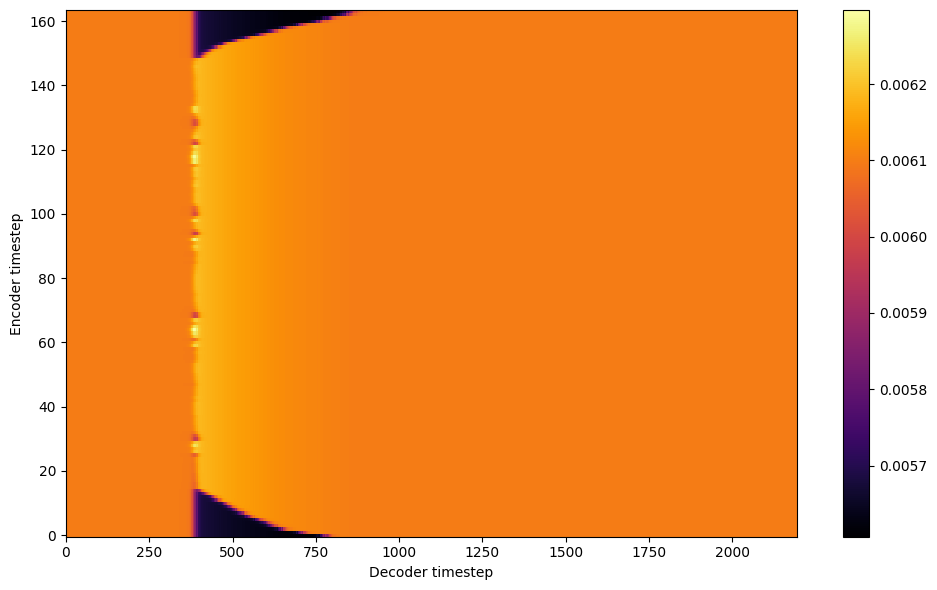


Starting Epoch: 23 Iteration: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 23 Validation loss 120:  9.481766  Time: 0.8m LR: 0.030000


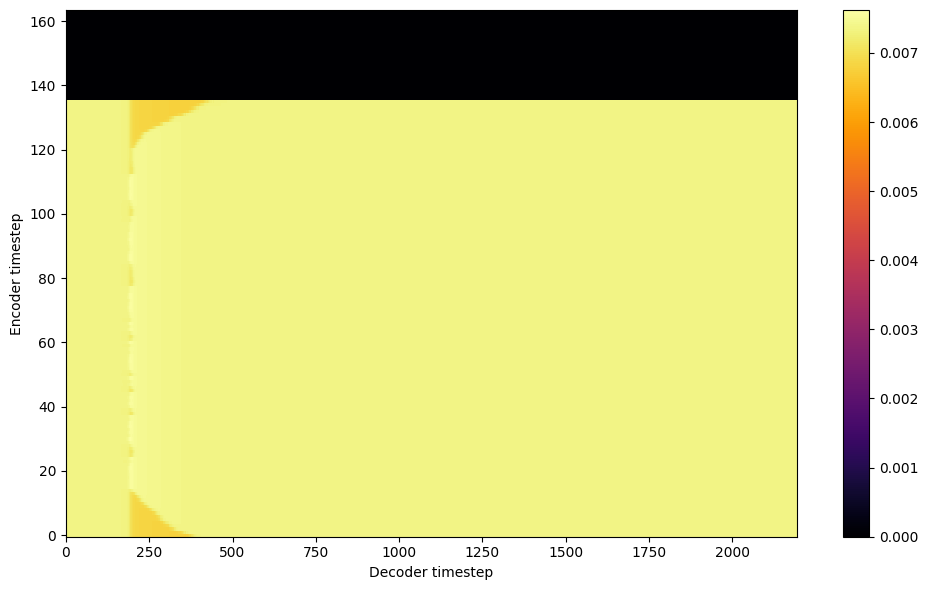


Starting Epoch: 24 Iteration: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 24 Validation loss 125:  8.909931  Time: 0.7m LR: 0.030000


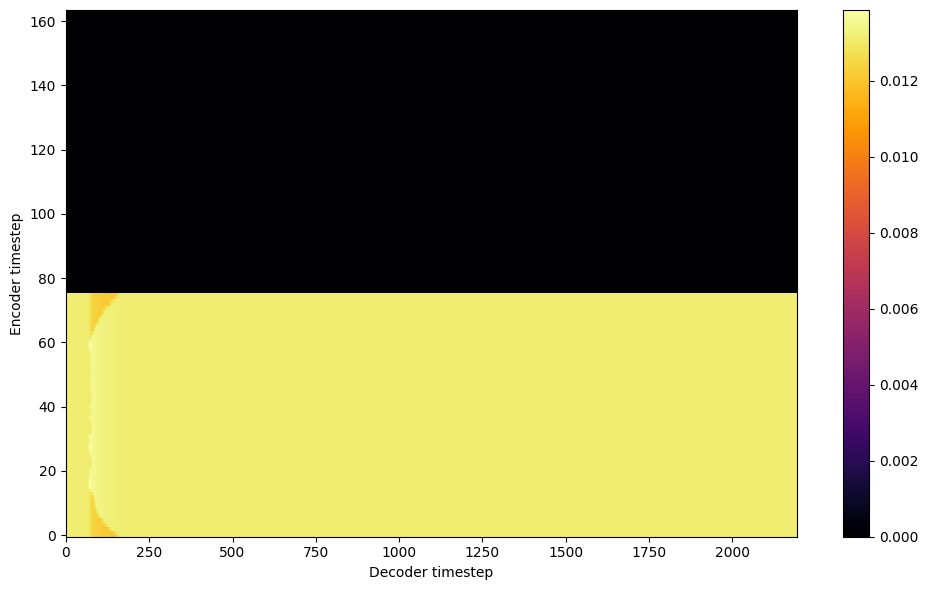


Starting Epoch: 25 Iteration: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 25 Validation loss 130:  8.936511  Time: 0.7m LR: 0.030000


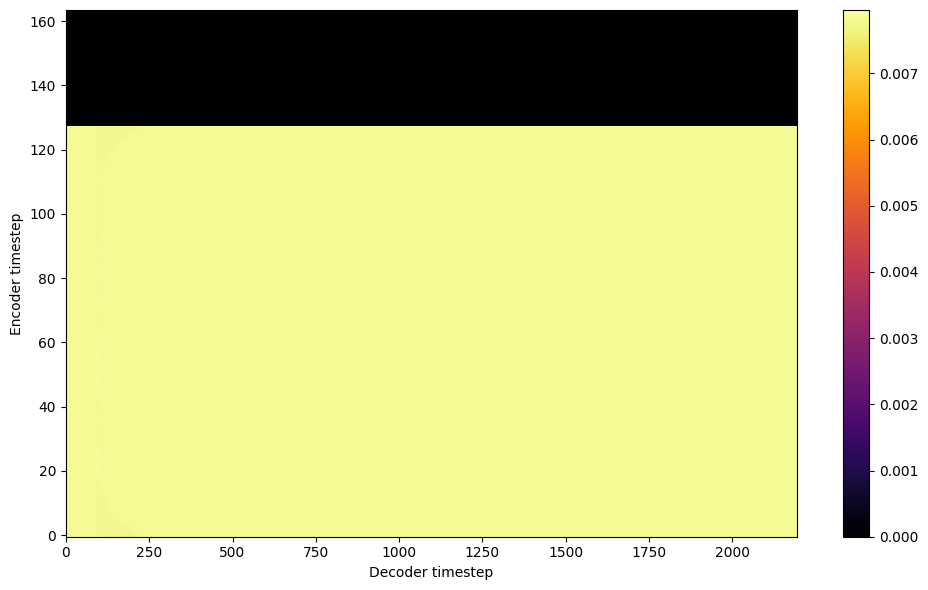


Starting Epoch: 26 Iteration: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 26 Validation loss 135:  8.824176  Time: 0.8m LR: 0.030000


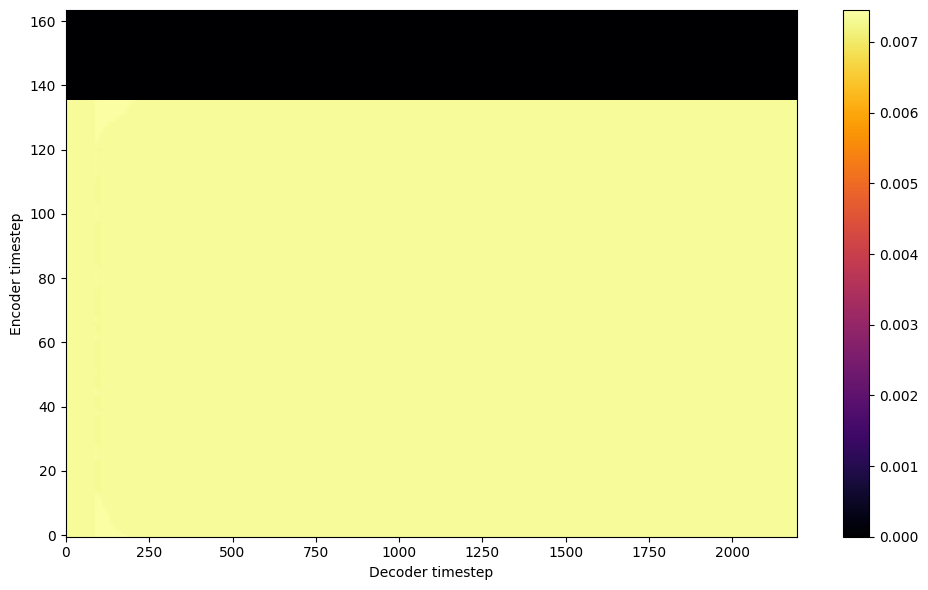


Starting Epoch: 27 Iteration: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 27 Validation loss 140:  8.722363  Time: 0.7m LR: 0.030000


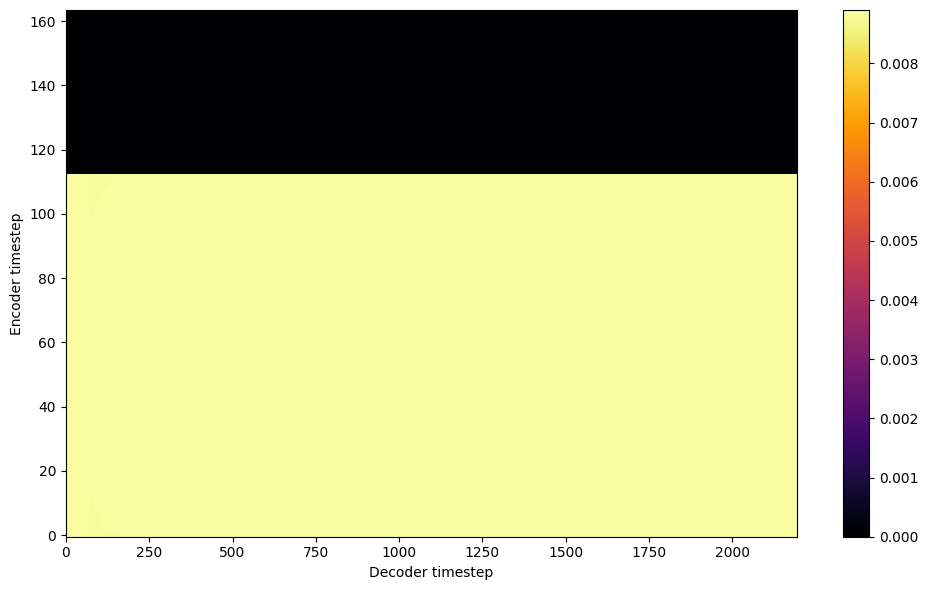


Starting Epoch: 28 Iteration: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 28 Validation loss 145:  8.697274  Time: 0.8m LR: 0.030000


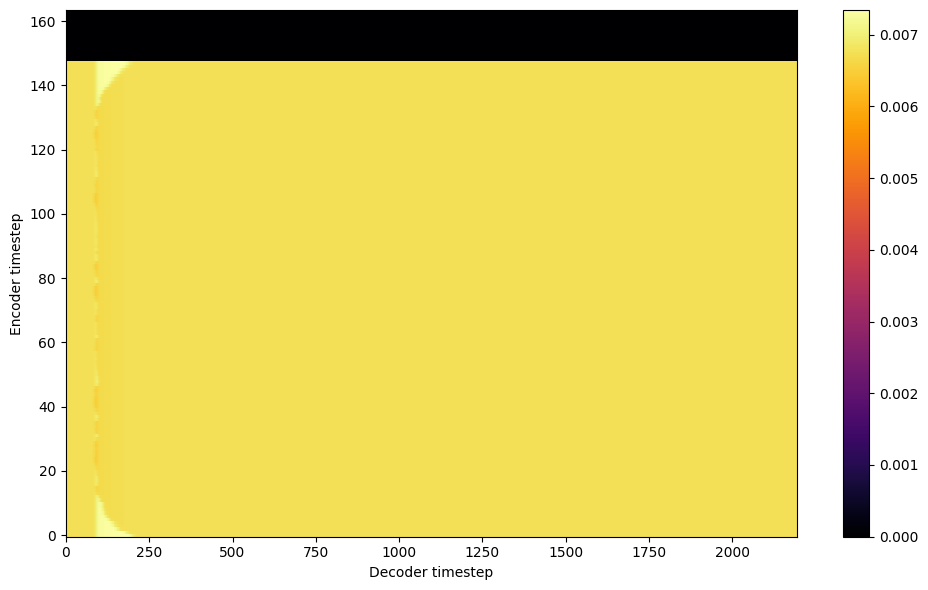


Starting Epoch: 29 Iteration: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 29 Validation loss 150:  9.018902  Time: 0.7m LR: 0.030000


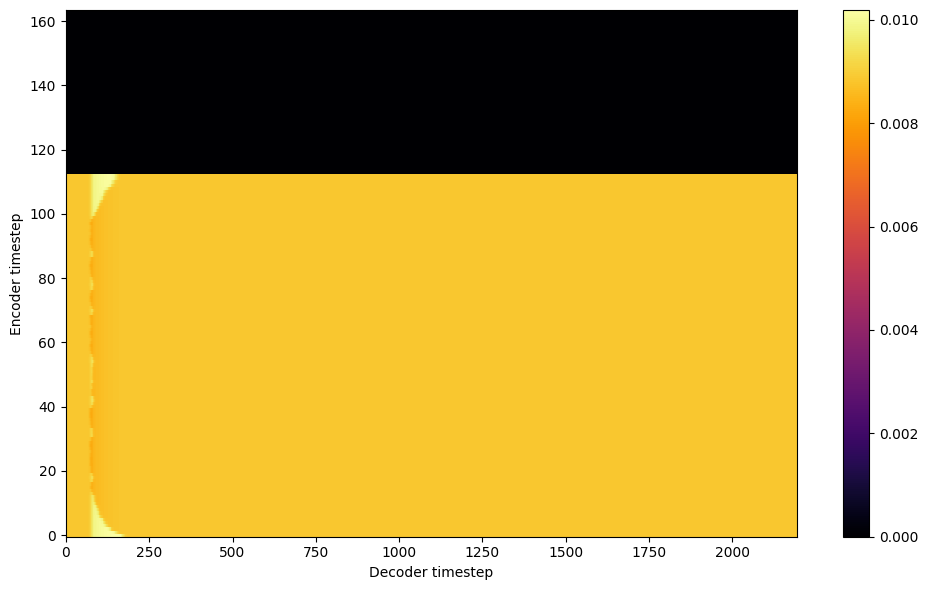

Saving model and optimizer state at iteration 150 to /content/drive/MyDrive/colab/outdir/modijii-40
Model Saved

Starting Epoch: 30 Iteration: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 30 Validation loss 155:  9.129993  Time: 0.8m LR: 0.030000


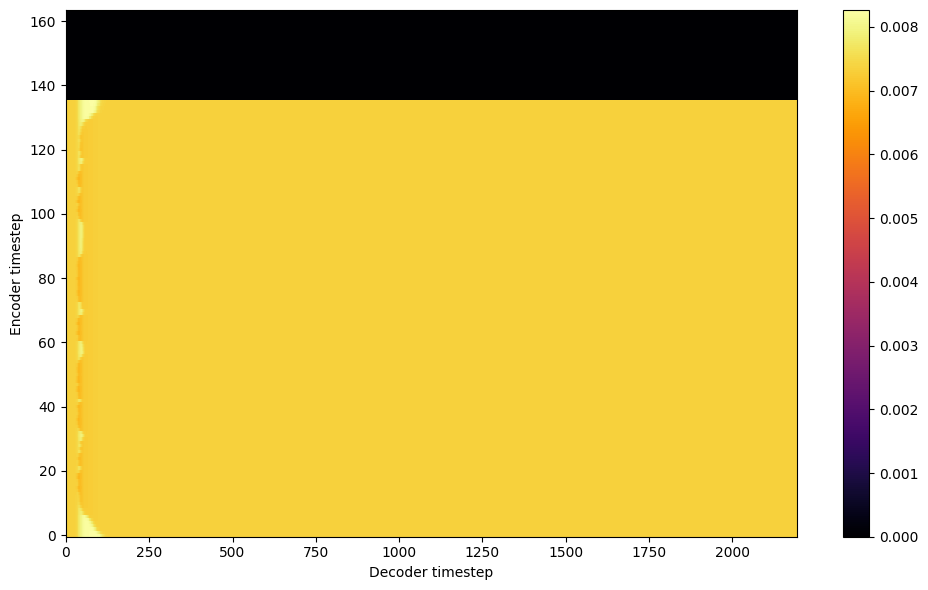


Starting Epoch: 31 Iteration: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 31 Validation loss 160:  9.701334  Time: 0.8m LR: 0.030000


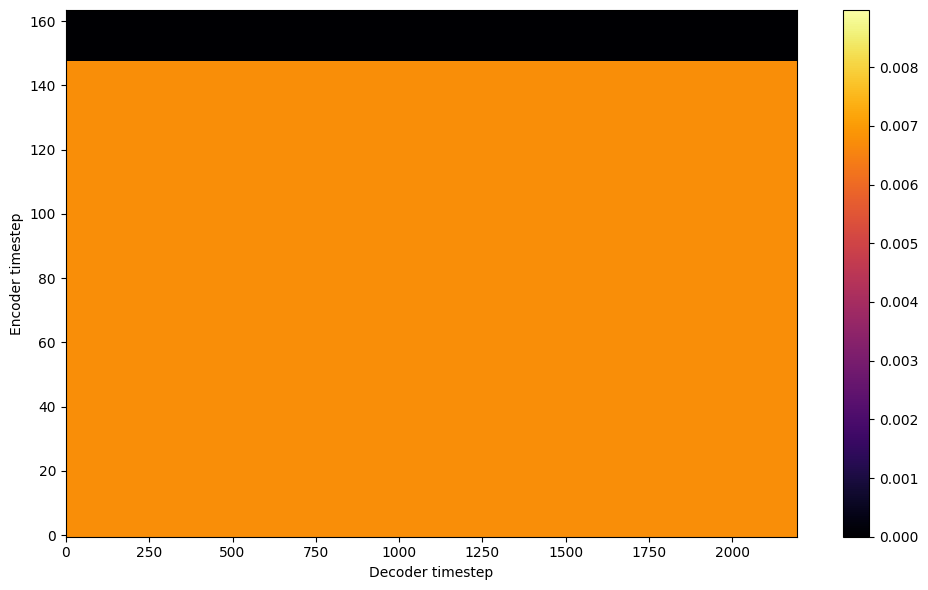


Starting Epoch: 32 Iteration: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 32 Validation loss 165:  9.355116  Time: 0.8m LR: 0.030000


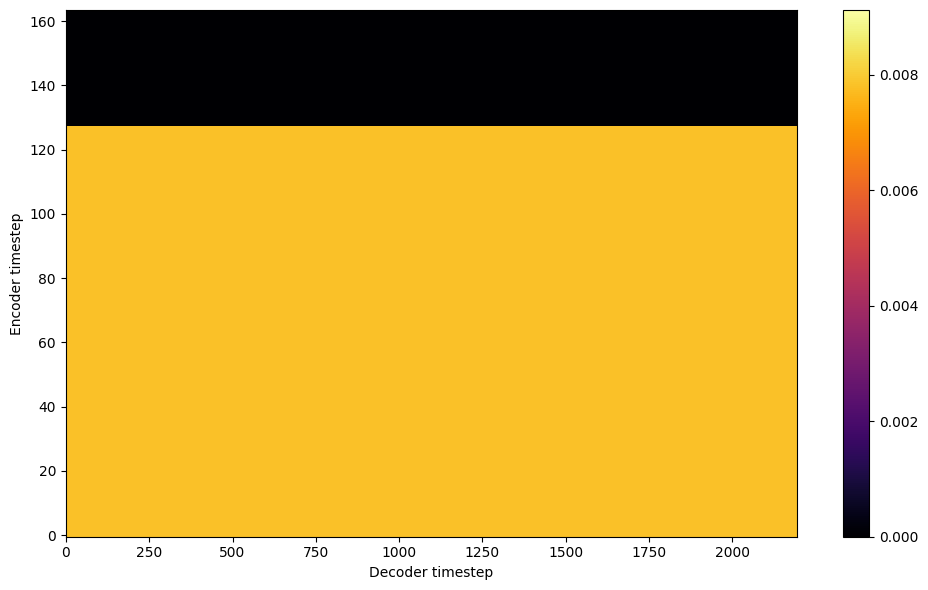


Starting Epoch: 33 Iteration: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 33 Validation loss 170:  8.794501  Time: 0.8m LR: 0.030000


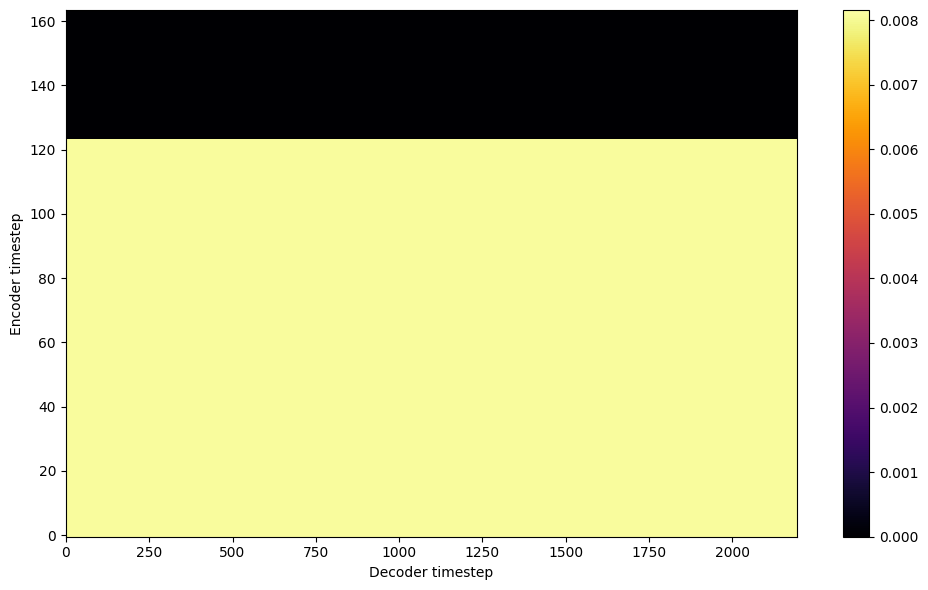


Starting Epoch: 34 Iteration: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 34 Validation loss 175:  8.718753  Time: 0.7m LR: 0.030000


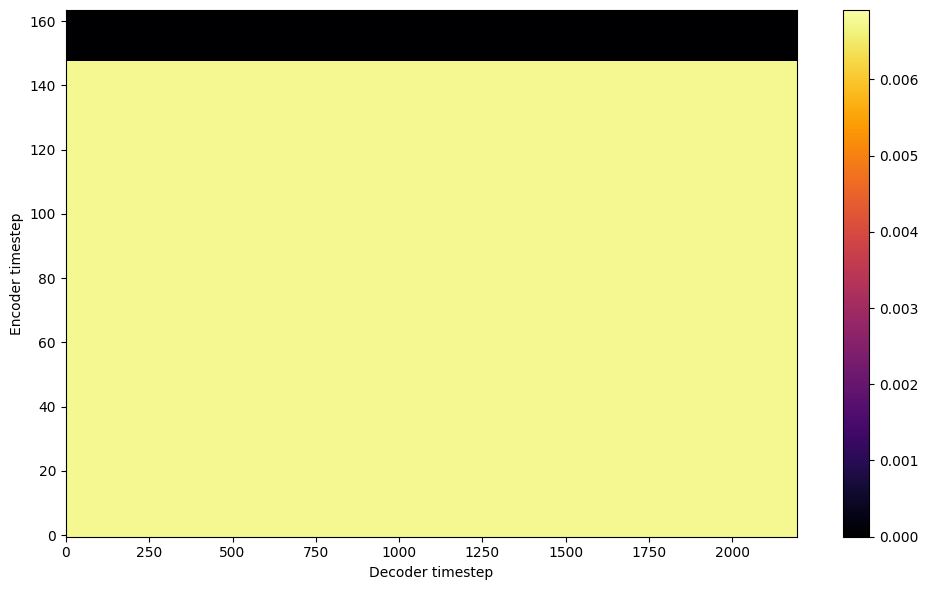


Starting Epoch: 35 Iteration: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 35 Validation loss 180:  9.561094  Time: 0.8m LR: 0.030000


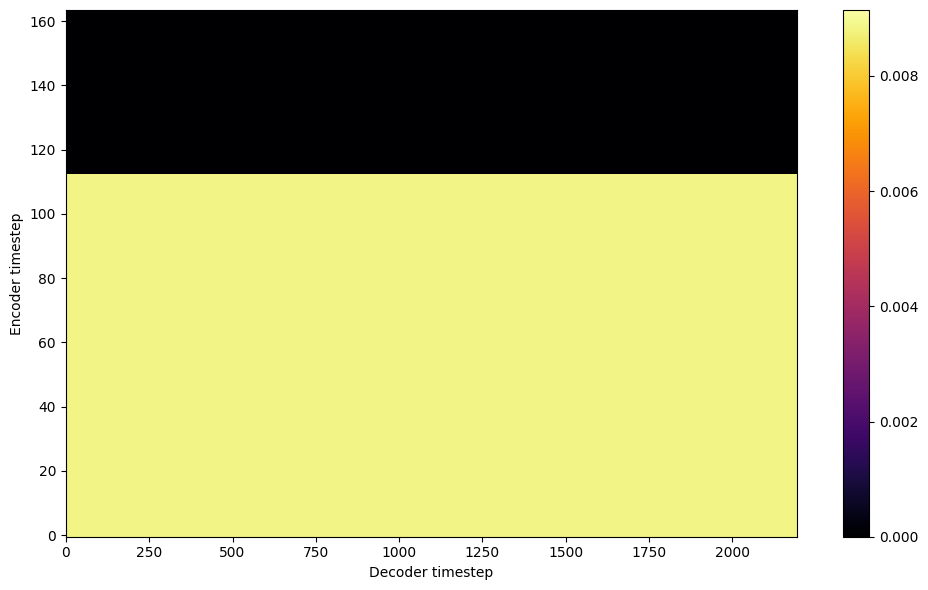


Starting Epoch: 36 Iteration: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 36 Validation loss 185:  8.659697  Time: 0.7m LR: 0.030000


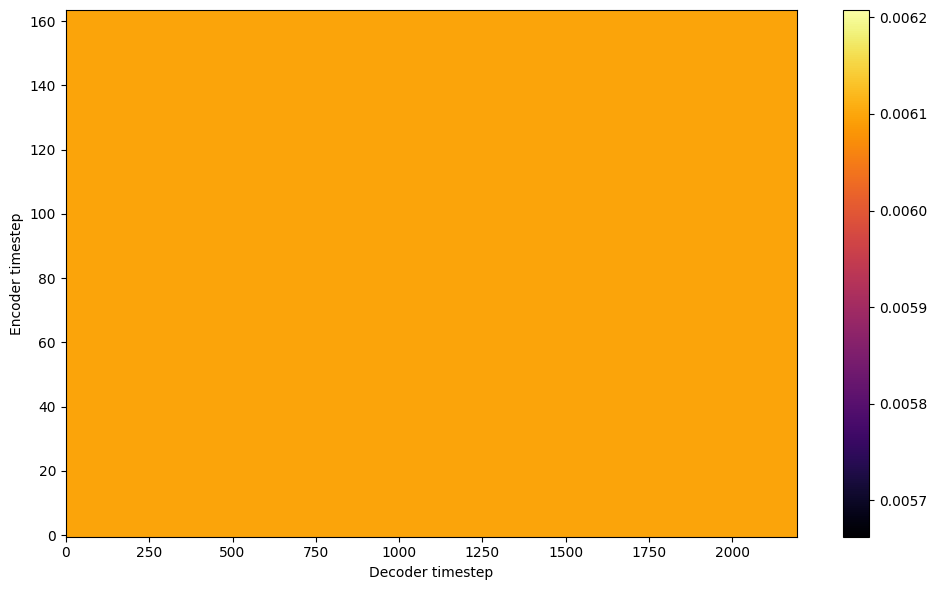


Starting Epoch: 37 Iteration: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 37 Validation loss 190:  8.691815  Time: 0.7m LR: 0.030000


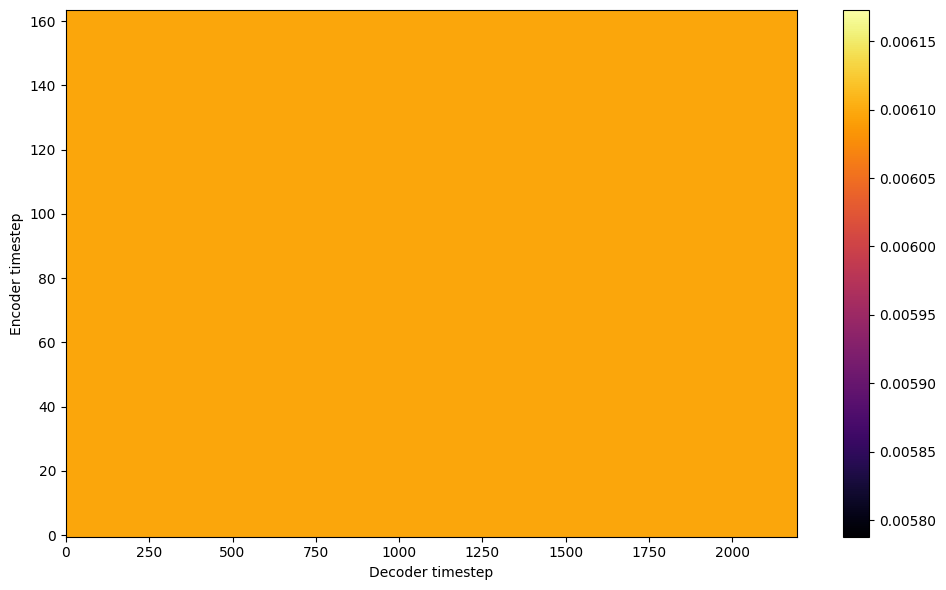


Starting Epoch: 38 Iteration: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 38 Validation loss 195:  9.406298  Time: 0.7m LR: 0.030000


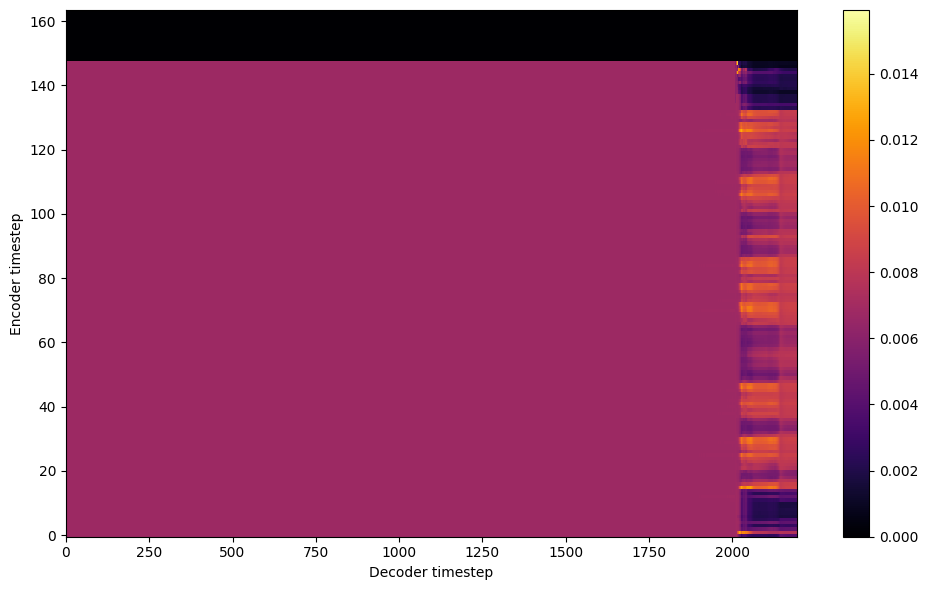


Starting Epoch: 39 Iteration: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 39 Validation loss 200:  9.661853  Time: 0.7m LR: 0.030000


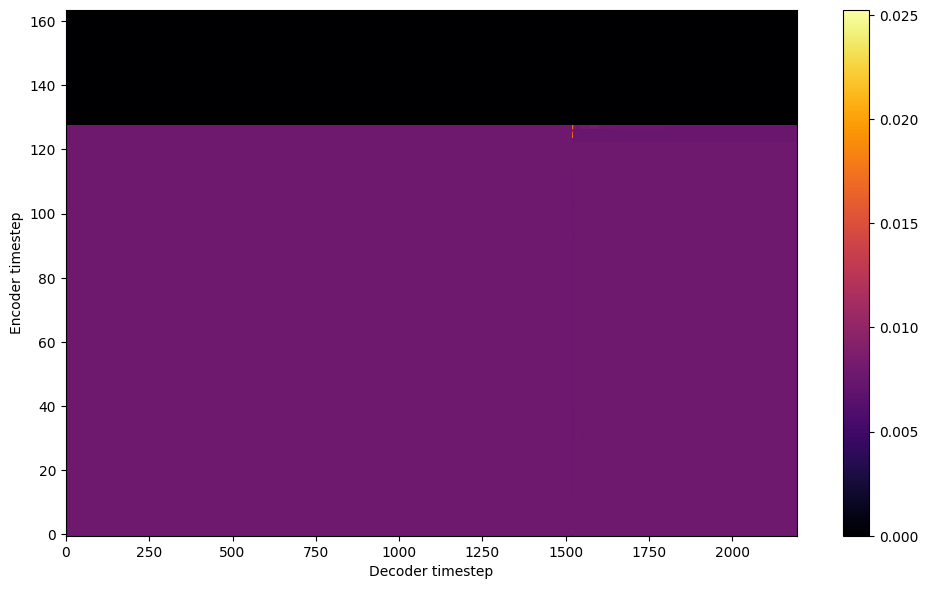

Saving model and optimizer state at iteration 200 to /content/drive/MyDrive/colab/outdir/modijii-40
Model Saved

Starting Epoch: 40 Iteration: 200


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 40 Validation loss 205:  8.781627  Time: 0.7m LR: 0.030000


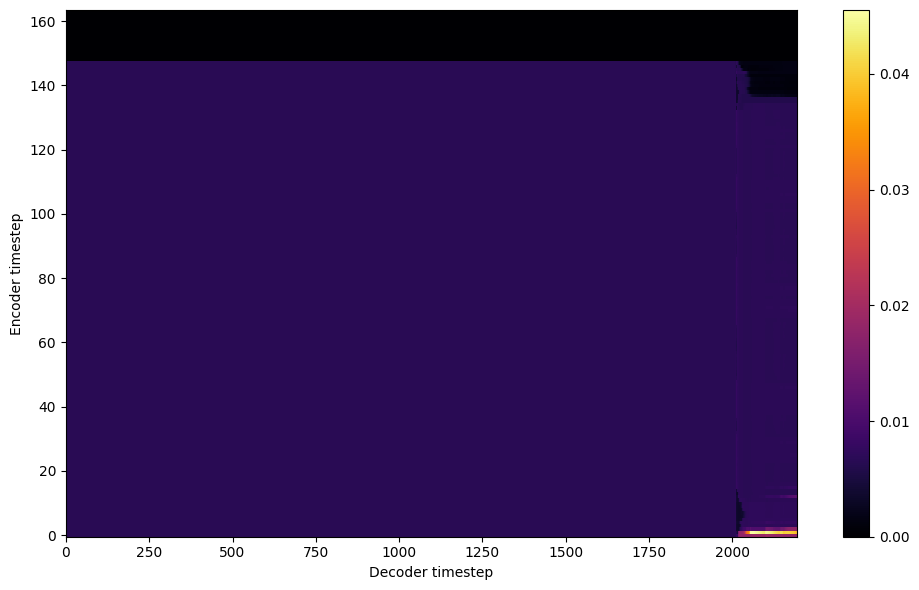


Starting Epoch: 41 Iteration: 205


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 41 Validation loss 210:  9.100627  Time: 0.7m LR: 0.030000


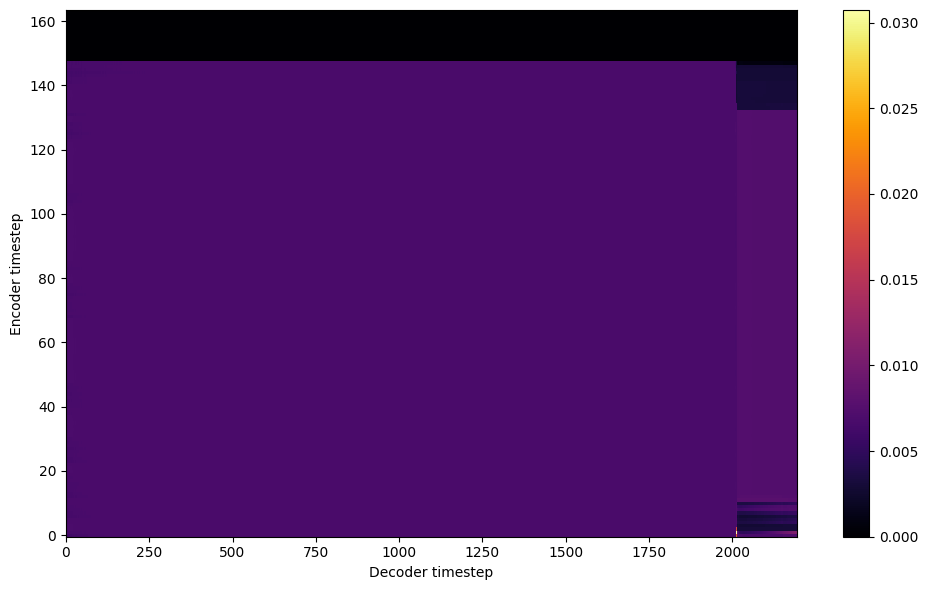


Starting Epoch: 42 Iteration: 210


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 42 Validation loss 215:  8.572161  Time: 0.7m LR: 0.030000


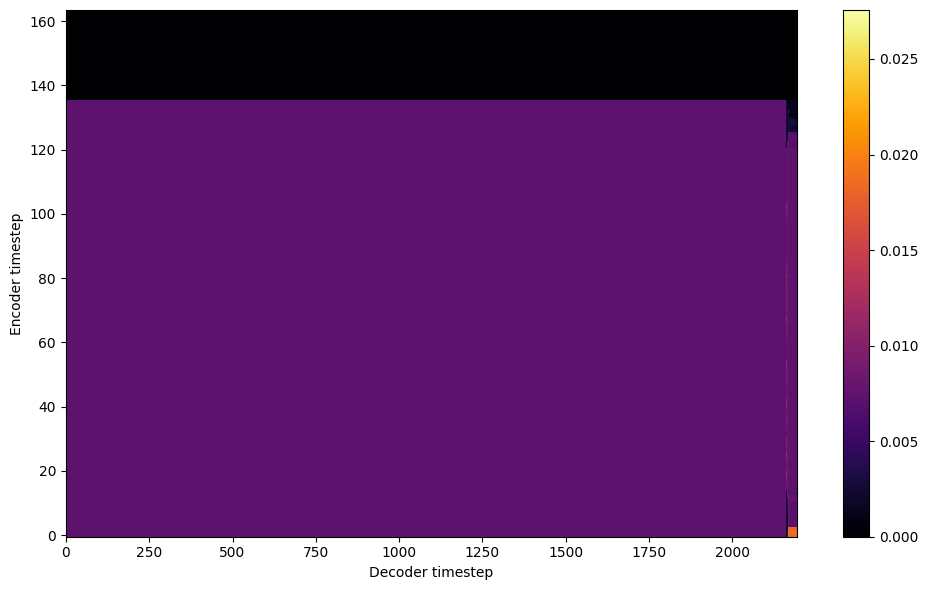


Starting Epoch: 43 Iteration: 215


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 43 Validation loss 220:  8.955393  Time: 0.7m LR: 0.030000


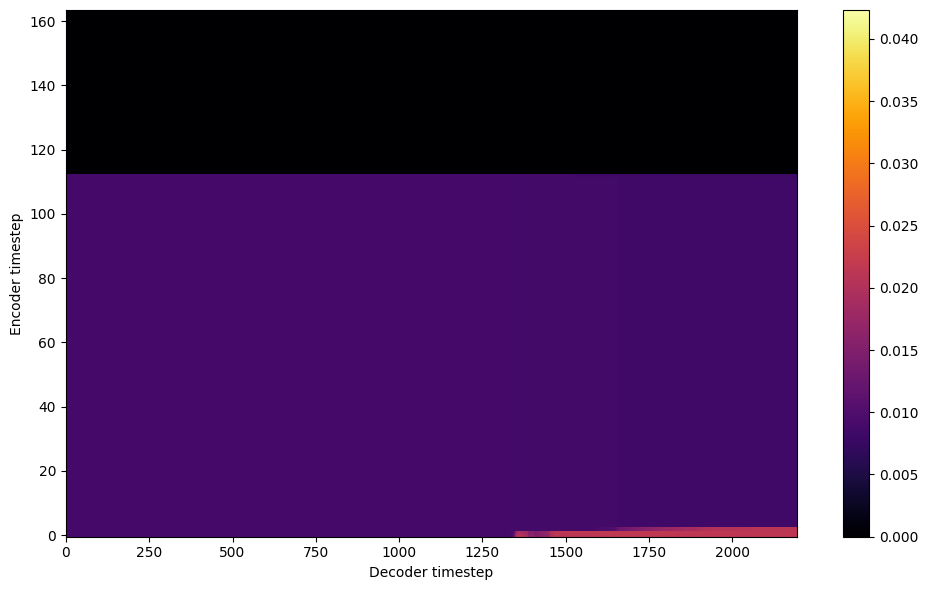


Starting Epoch: 44 Iteration: 220


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 44 Validation loss 225:  8.793365  Time: 0.8m LR: 0.030000


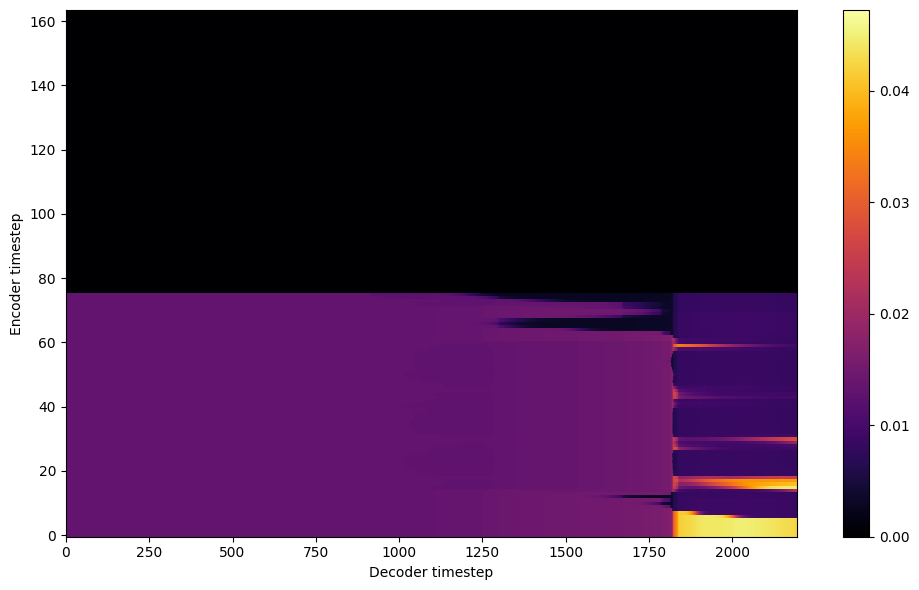


Starting Epoch: 45 Iteration: 225


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 45 Validation loss 230:  8.531981  Time: 0.8m LR: 0.030000


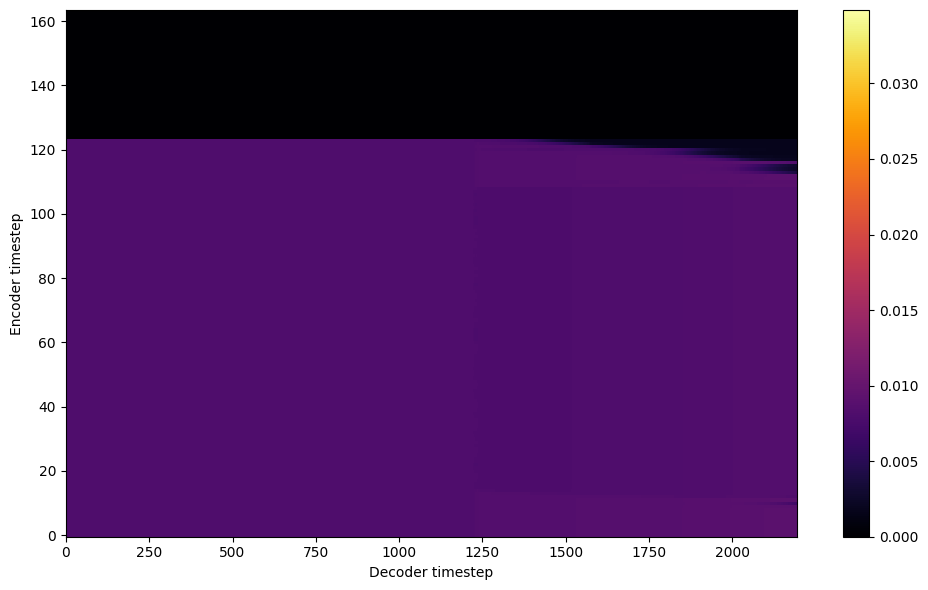


Starting Epoch: 46 Iteration: 230


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 46 Validation loss 235:  8.794434  Time: 0.7m LR: 0.030000


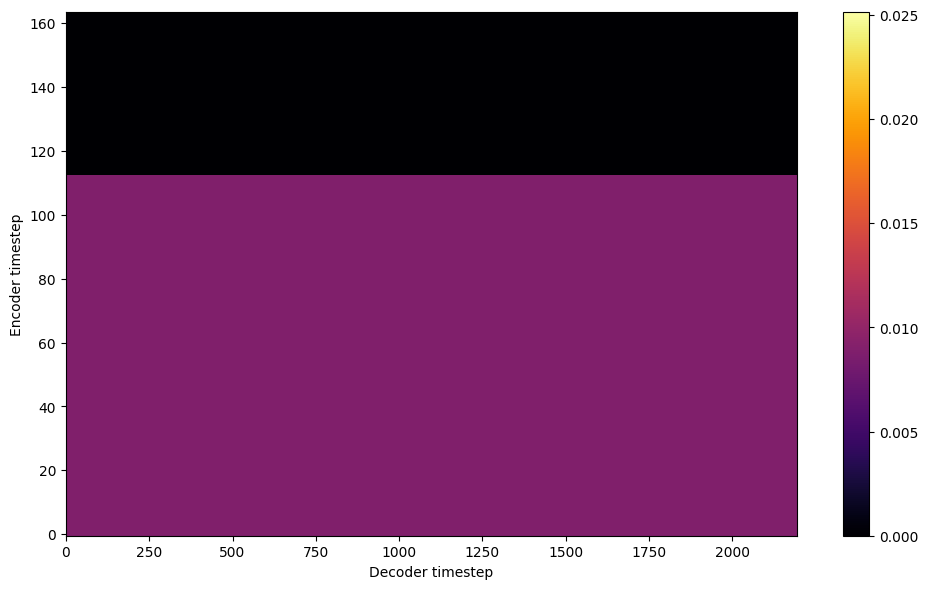


Starting Epoch: 47 Iteration: 235


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 47 Validation loss 240:  8.534918  Time: 0.8m LR: 0.030000


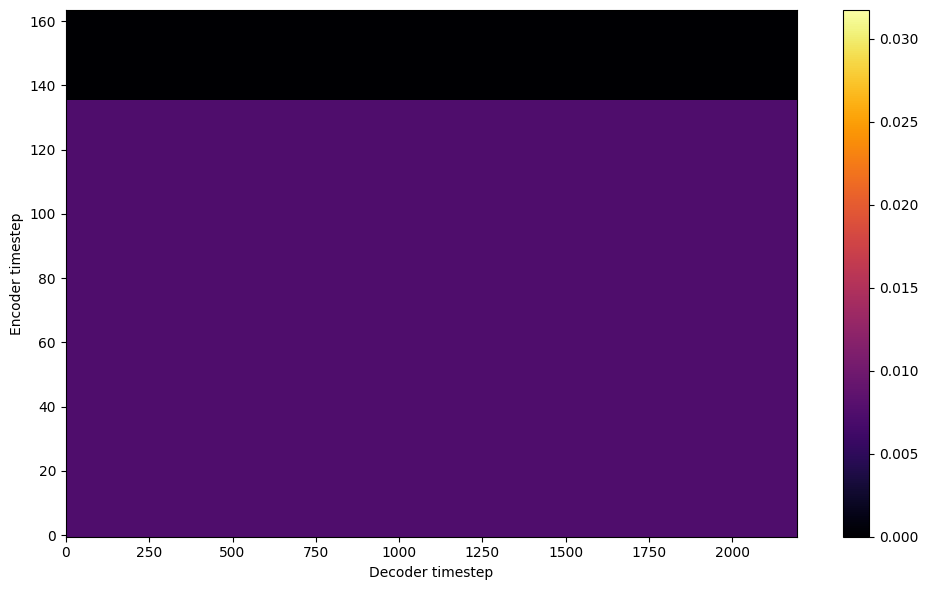


Starting Epoch: 48 Iteration: 240


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 48 Validation loss 245:  9.093440  Time: 0.7m LR: 0.030000


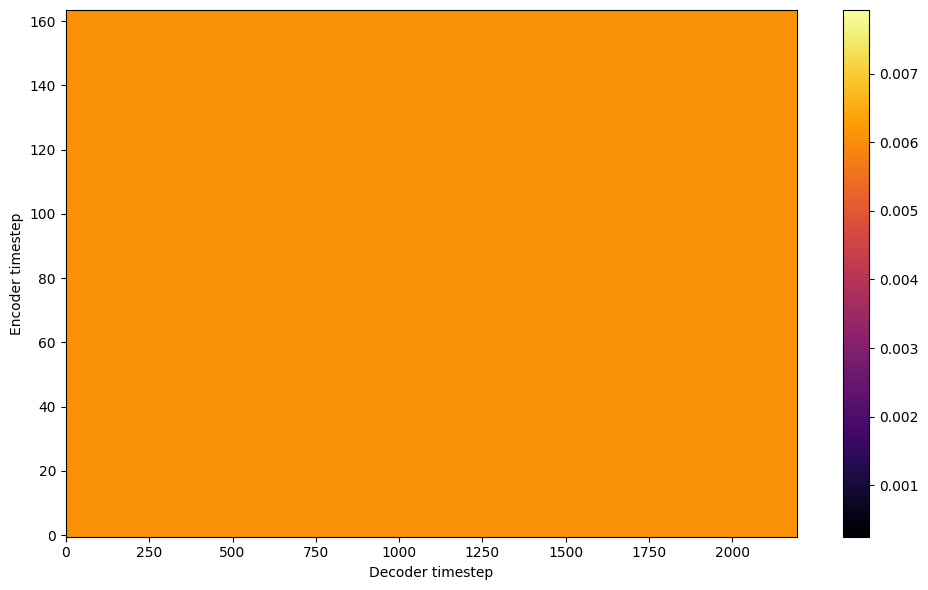


Starting Epoch: 49 Iteration: 245


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 49 Validation loss 250:  9.129326  Time: 0.8m LR: 0.030000


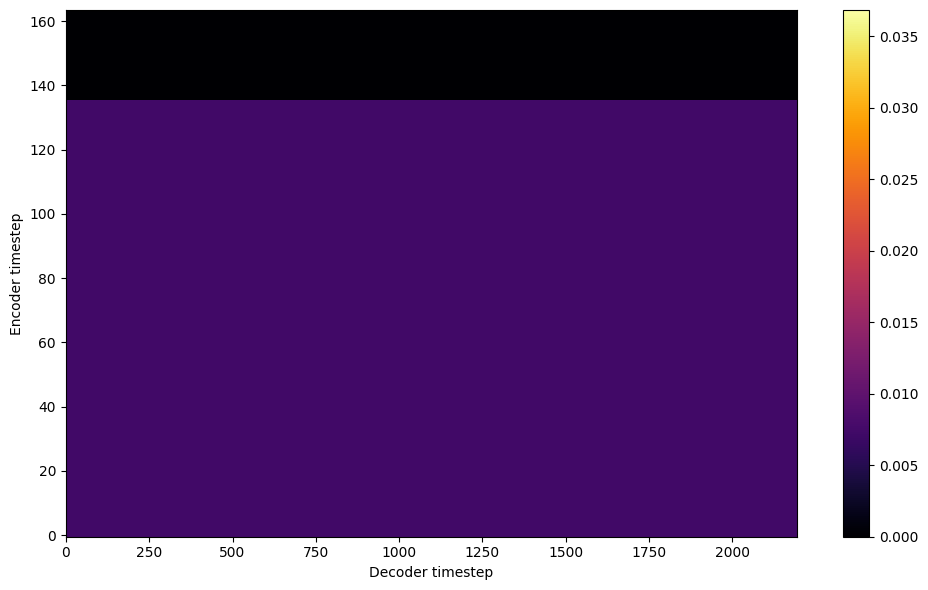

Saving model and optimizer state at iteration 250 to /content/drive/MyDrive/colab/outdir/modijii-40
Model Saved

Starting Epoch: 50 Iteration: 250


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 50 Validation loss 255:  8.976598  Time: 0.7m LR: 0.030000


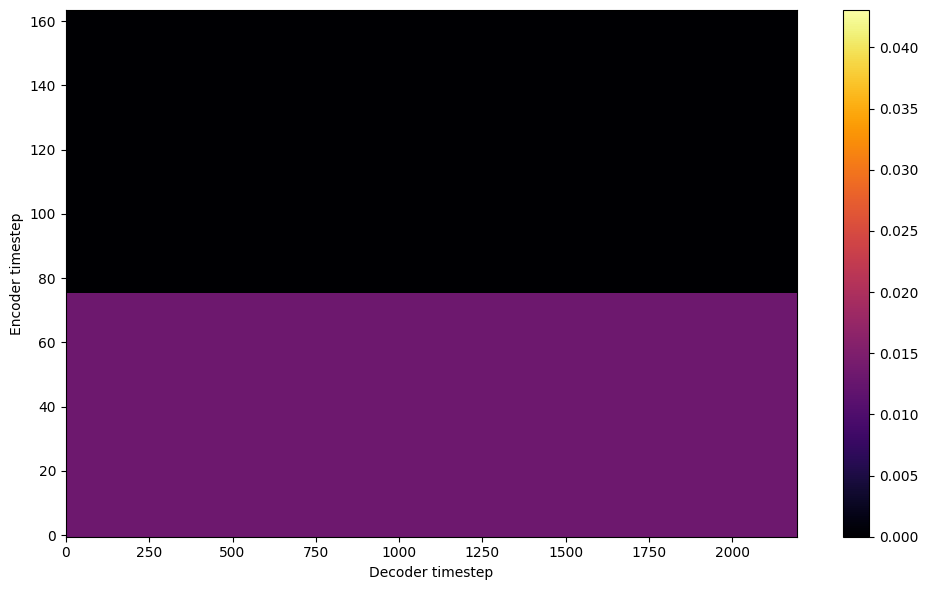


Starting Epoch: 51 Iteration: 255


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 51 Validation loss 260:  8.707774  Time: 0.7m LR: 0.030000


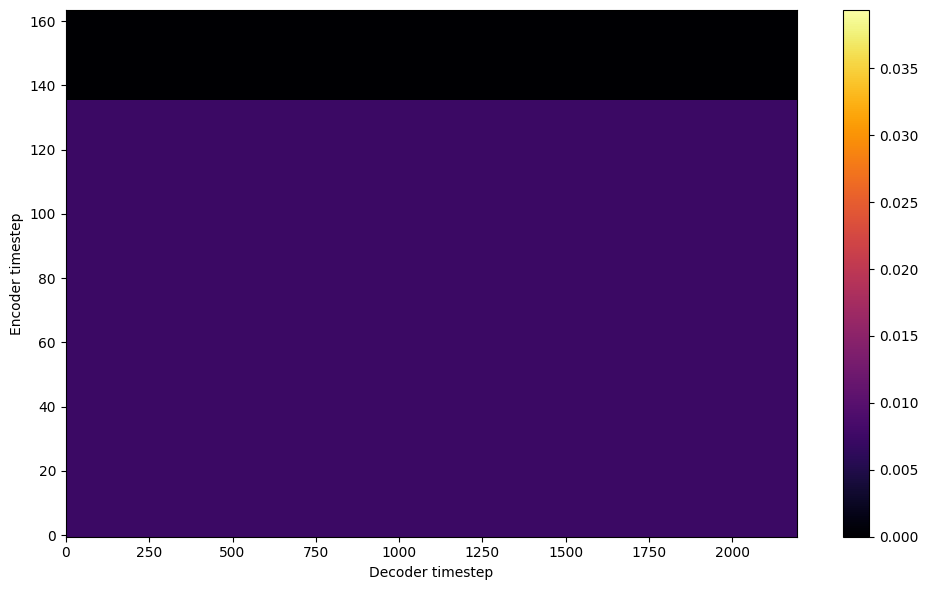


Starting Epoch: 52 Iteration: 260


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 52 Validation loss 265:  8.834110  Time: 0.8m LR: 0.030000


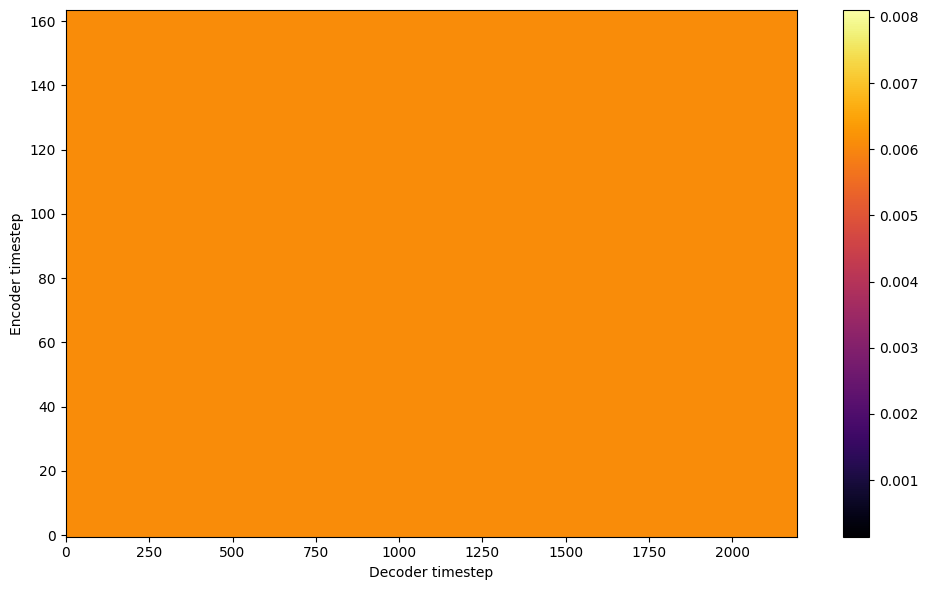


Starting Epoch: 53 Iteration: 265


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 53 Validation loss 270:  8.814397  Time: 0.8m LR: 0.030000


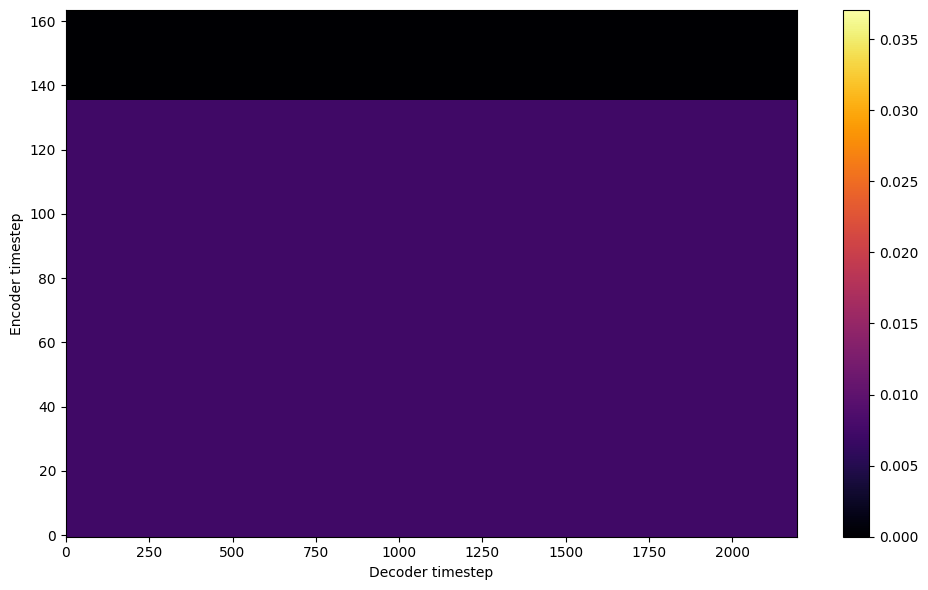


Starting Epoch: 54 Iteration: 270


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 54 Validation loss 275:  8.399700  Time: 0.8m LR: 0.030000


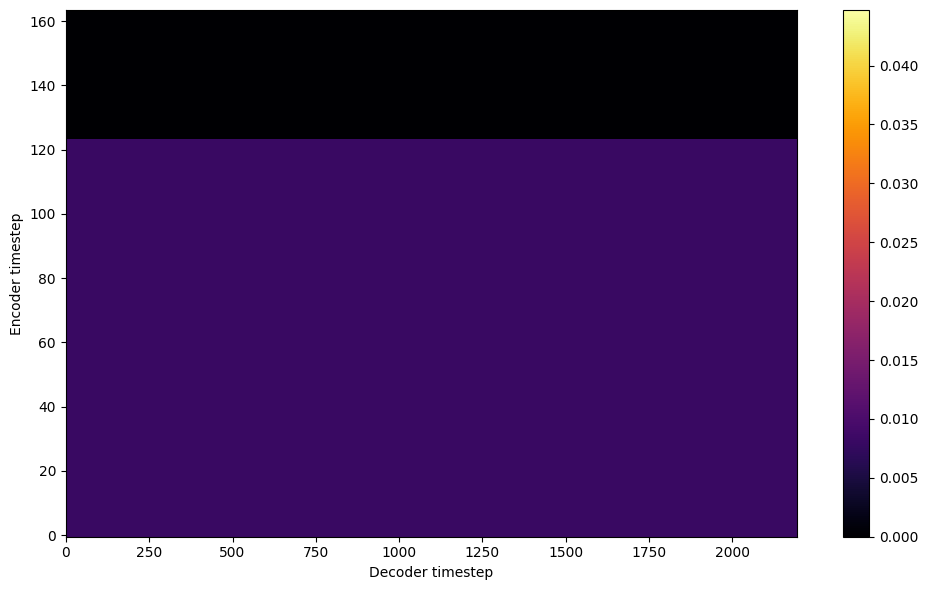


Starting Epoch: 55 Iteration: 275


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 55 Validation loss 280:  8.844091  Time: 0.8m LR: 0.030000


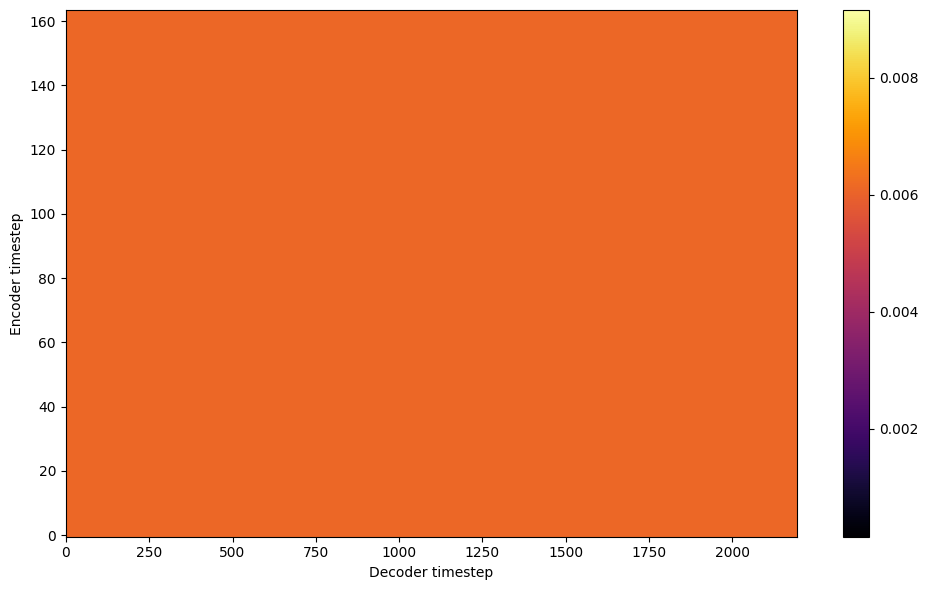


Starting Epoch: 56 Iteration: 280


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 56 Validation loss 285:  8.692208  Time: 0.8m LR: 0.030000


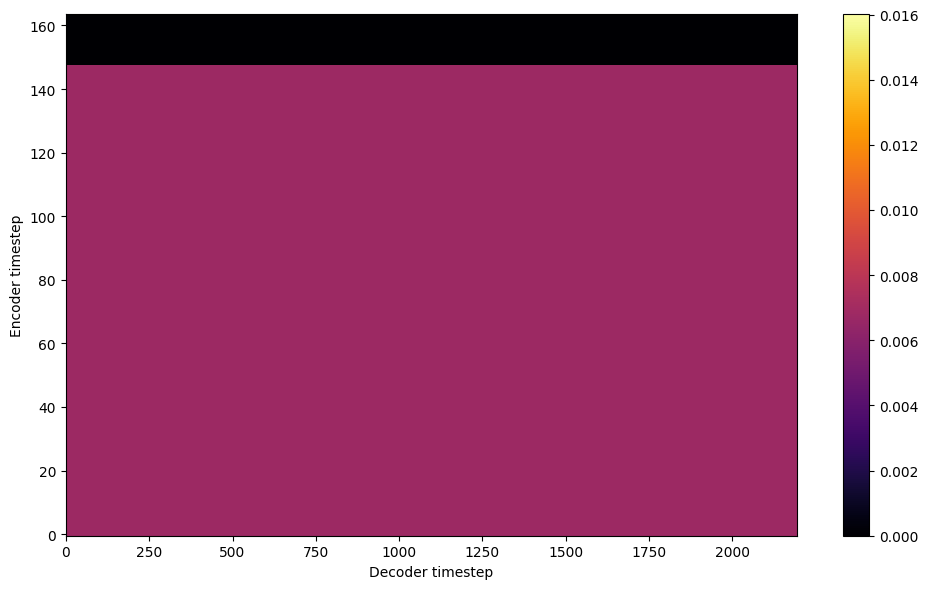


Starting Epoch: 57 Iteration: 285


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 57 Validation loss 290:  8.592756  Time: 0.7m LR: 0.030000


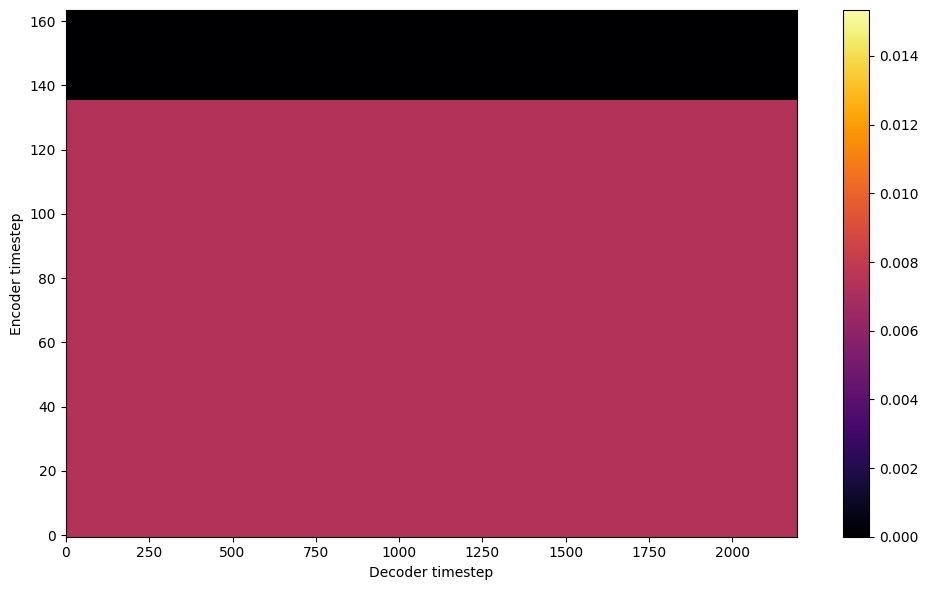


Starting Epoch: 58 Iteration: 290


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 58 Validation loss 295:  8.683928  Time: 0.8m LR: 0.030000


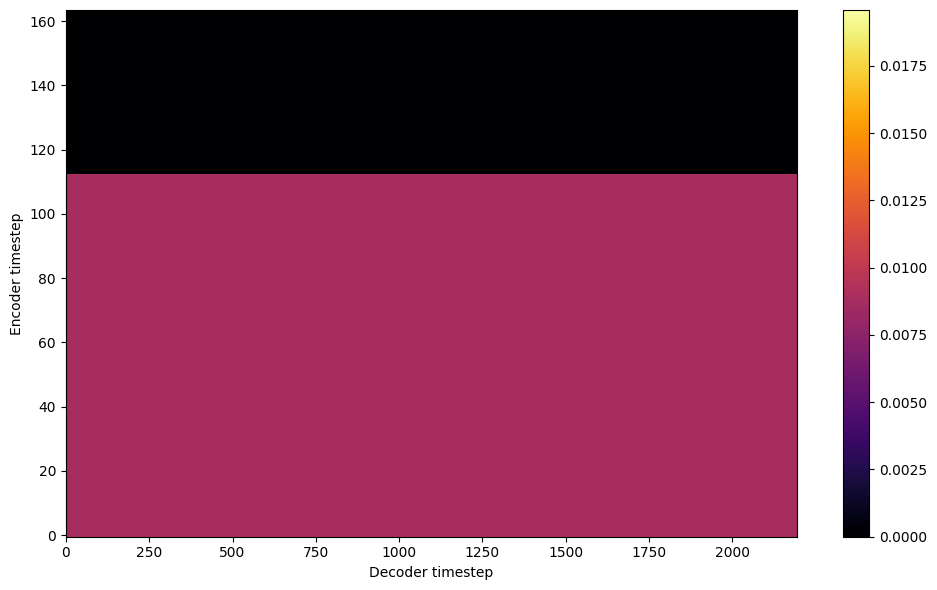


Starting Epoch: 59 Iteration: 295


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 59 Validation loss 300:  8.878519  Time: 0.7m LR: 0.030000


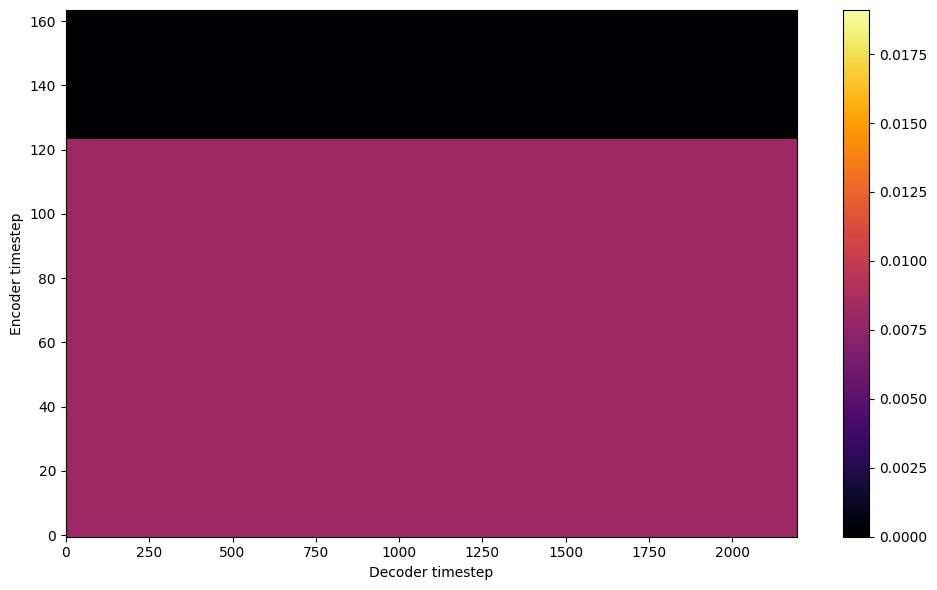

Saving model and optimizer state at iteration 300 to /content/drive/MyDrive/colab/outdir/modijii-40
Model Saved

Starting Epoch: 60 Iteration: 300


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 60 Validation loss 305:  9.089273  Time: 0.8m LR: 0.030000


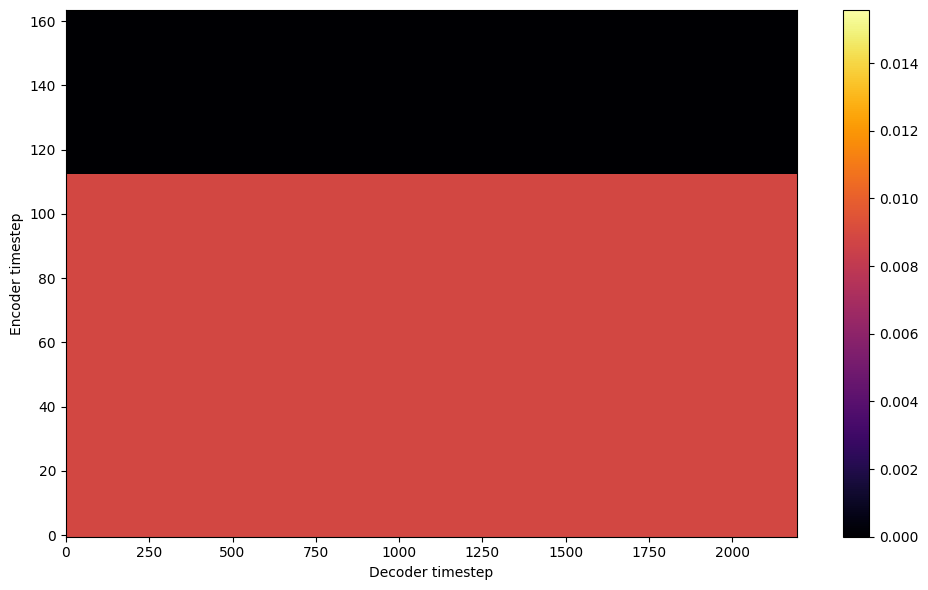


Starting Epoch: 61 Iteration: 305


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 61 Validation loss 310:  8.440844  Time: 0.8m LR: 0.030000


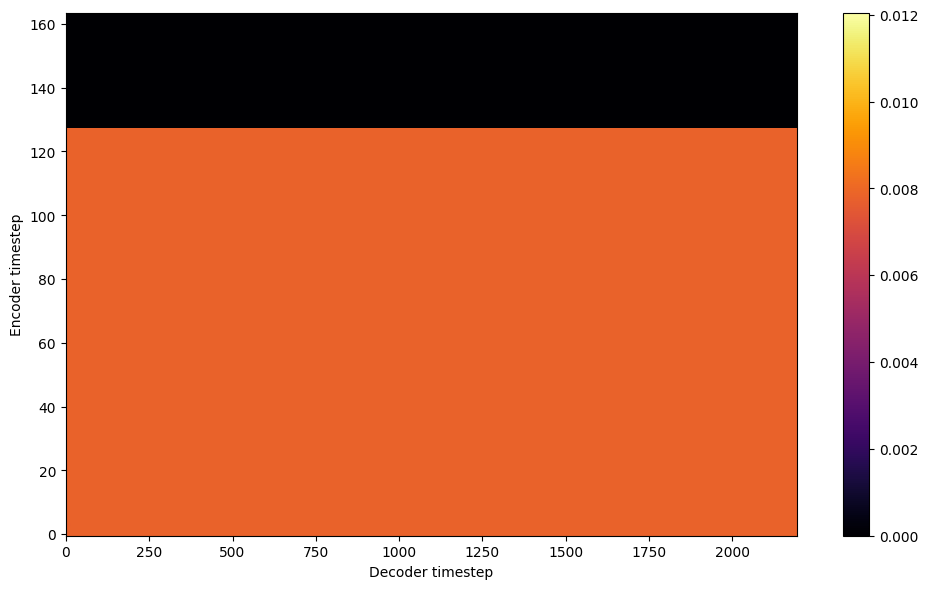


Starting Epoch: 62 Iteration: 310


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 62 Validation loss 315:  8.828758  Time: 0.7m LR: 0.030000


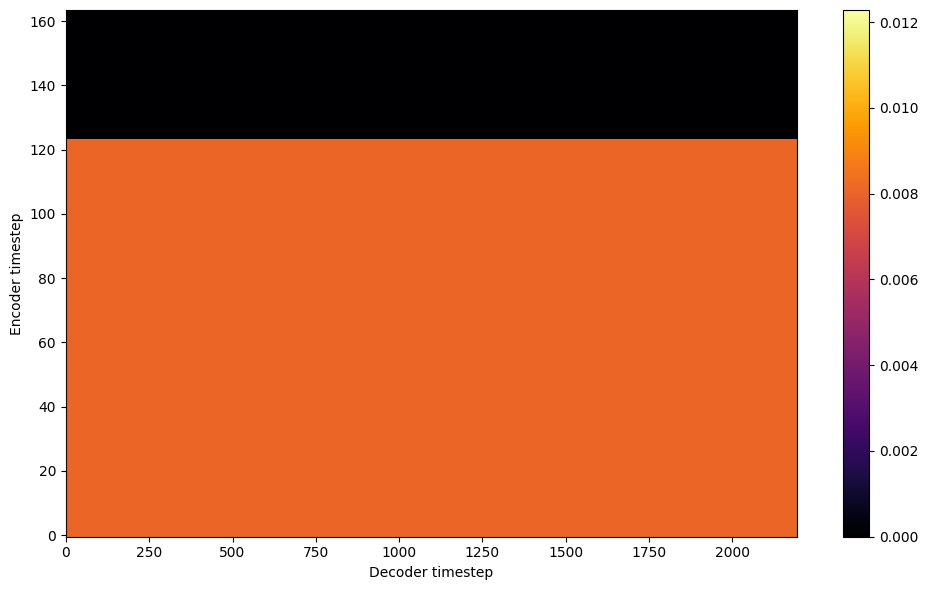


Starting Epoch: 63 Iteration: 315


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 63 Validation loss 320:  8.638902  Time: 0.8m LR: 0.030000


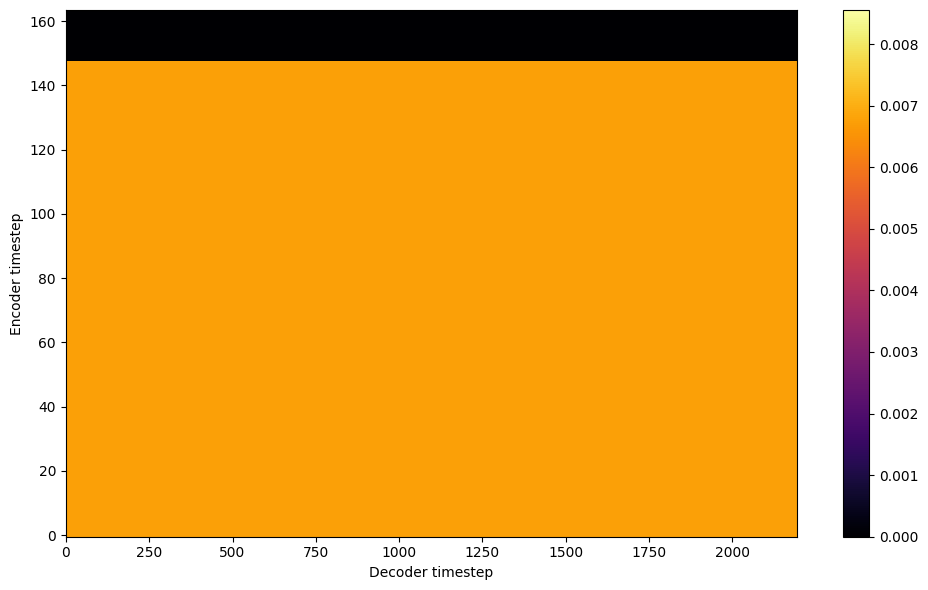


Starting Epoch: 64 Iteration: 320


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 64 Validation loss 325:  8.651385  Time: 0.7m LR: 0.030000


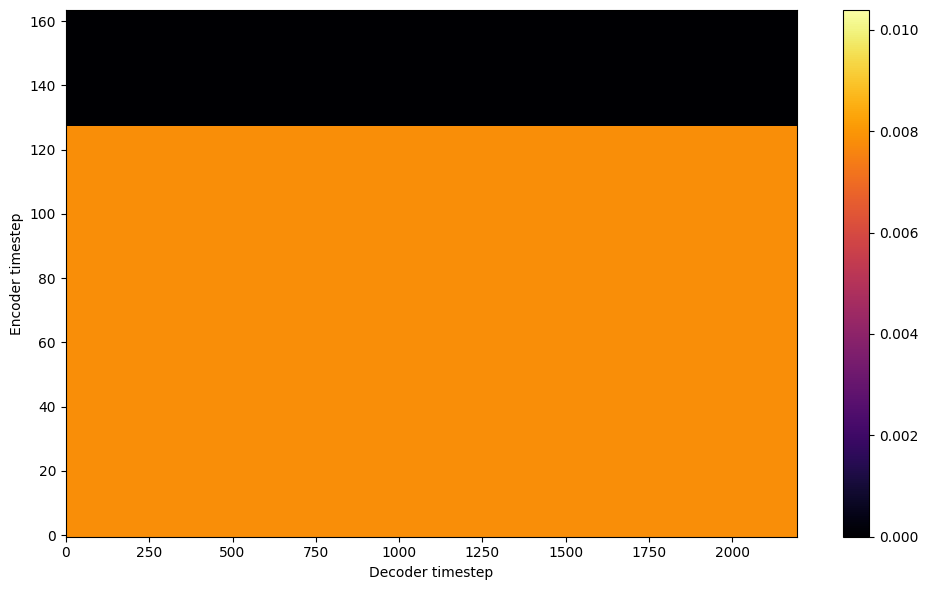


Starting Epoch: 65 Iteration: 325


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 65 Validation loss 330:  8.766321  Time: 0.8m LR: 0.030000


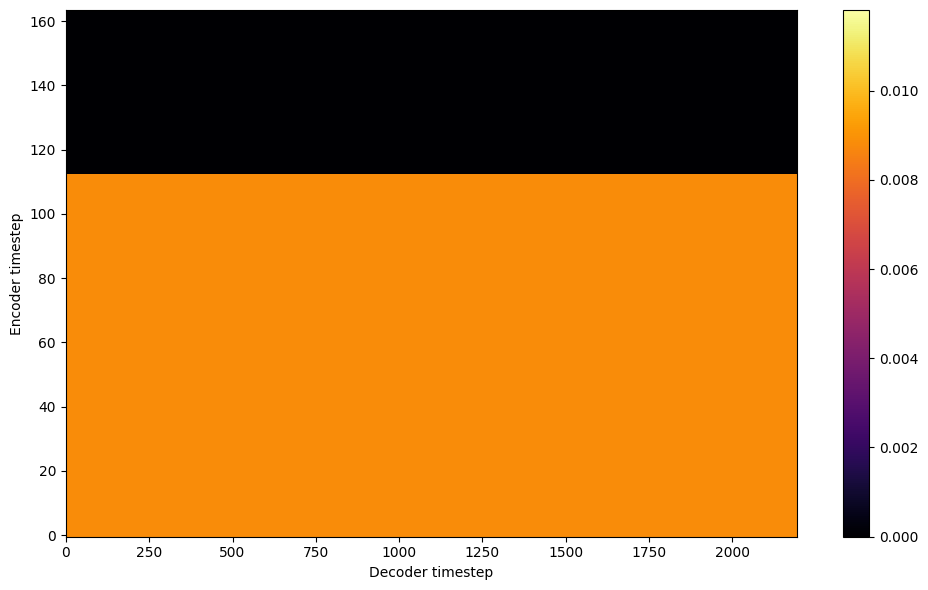


Starting Epoch: 66 Iteration: 330


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 66 Validation loss 335:  8.702615  Time: 0.7m LR: 0.030000


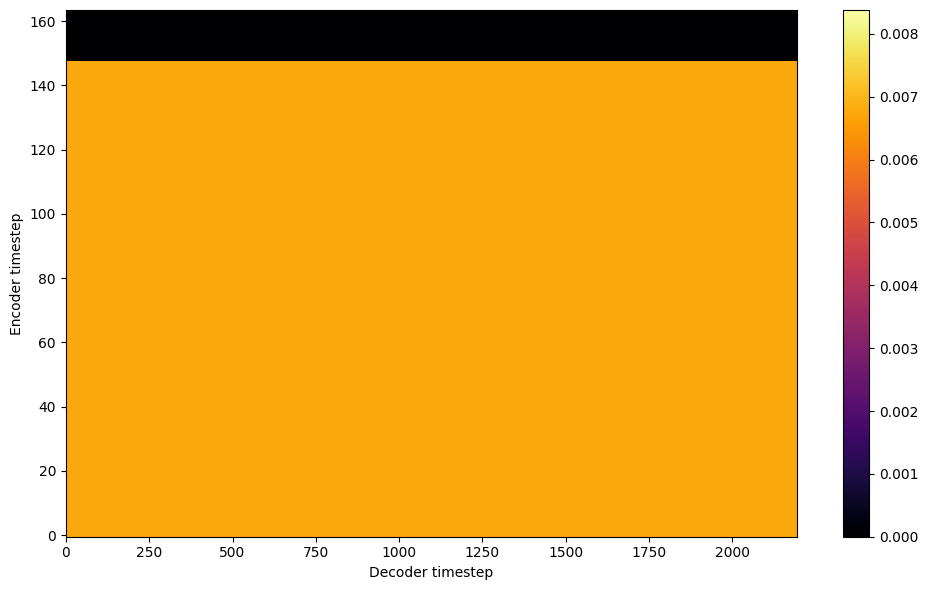


Starting Epoch: 67 Iteration: 335


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 67 Validation loss 340:  8.764948  Time: 0.7m LR: 0.030000


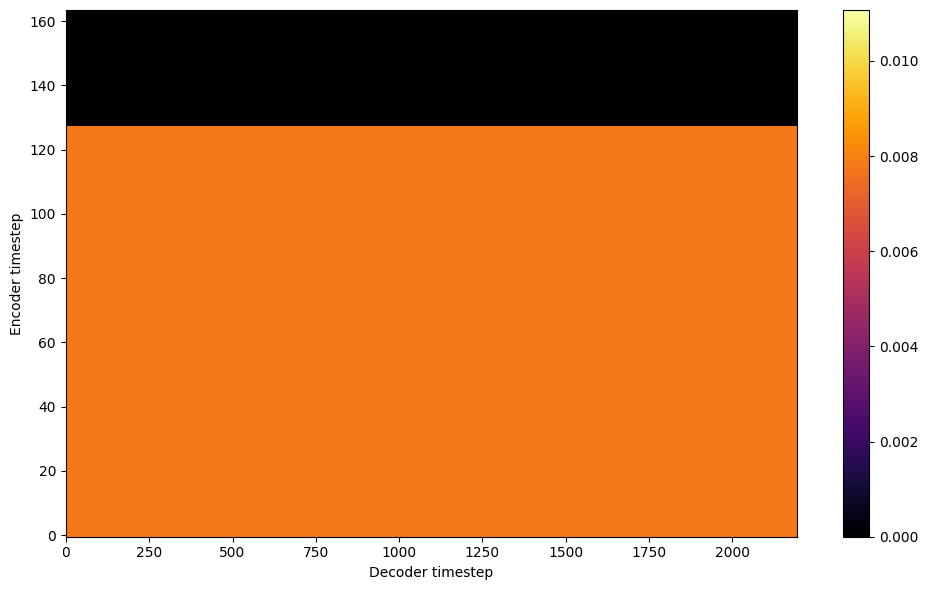


Starting Epoch: 68 Iteration: 340


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 68 Validation loss 345:  8.782528  Time: 0.8m LR: 0.030000


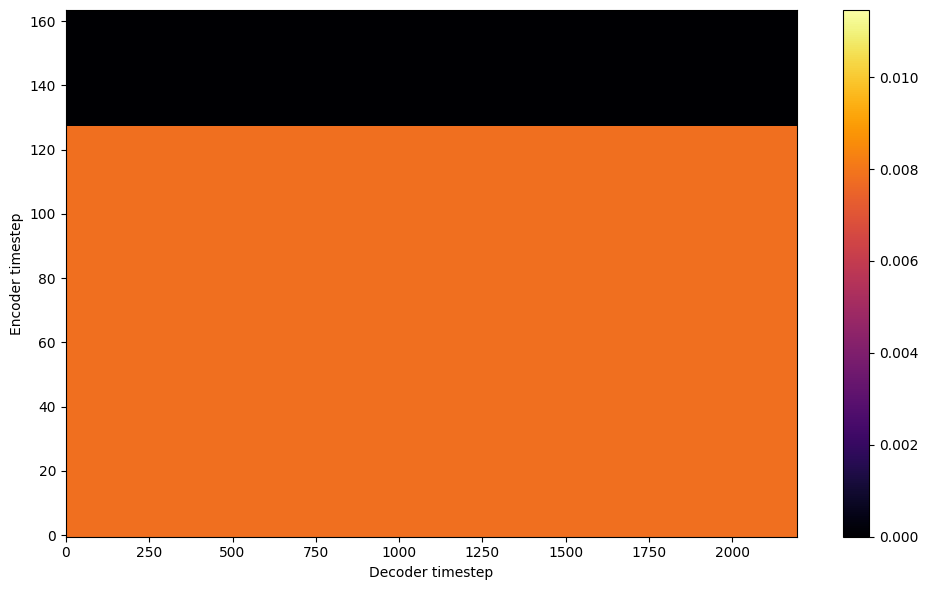


Starting Epoch: 69 Iteration: 345


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 69 Validation loss 350:  8.656563  Time: 0.8m LR: 0.030000


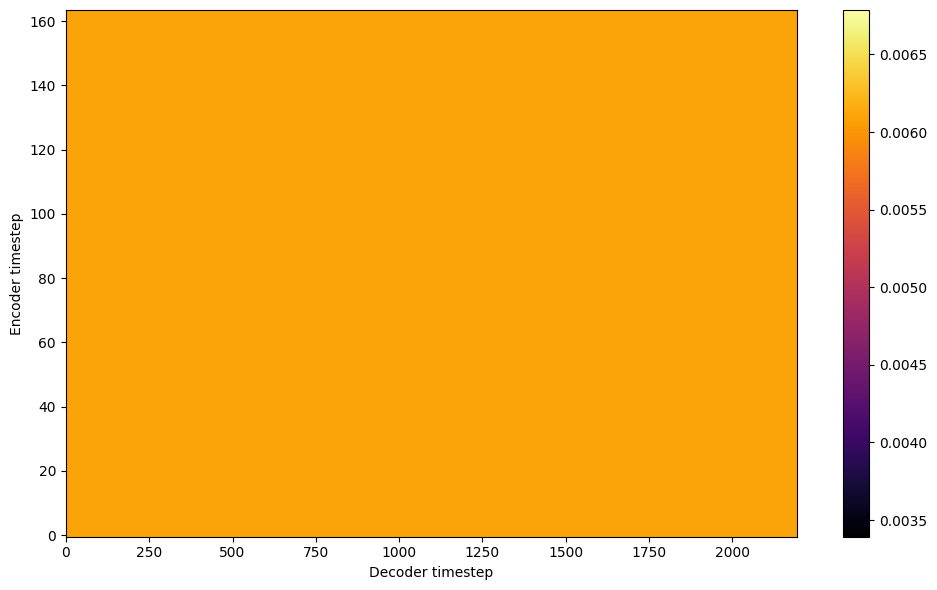

Saving model and optimizer state at iteration 350 to /content/drive/MyDrive/colab/outdir/modijii-40
Model Saved

Starting Epoch: 70 Iteration: 350


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 70 Validation loss 355:  8.941761  Time: 0.8m LR: 0.030000


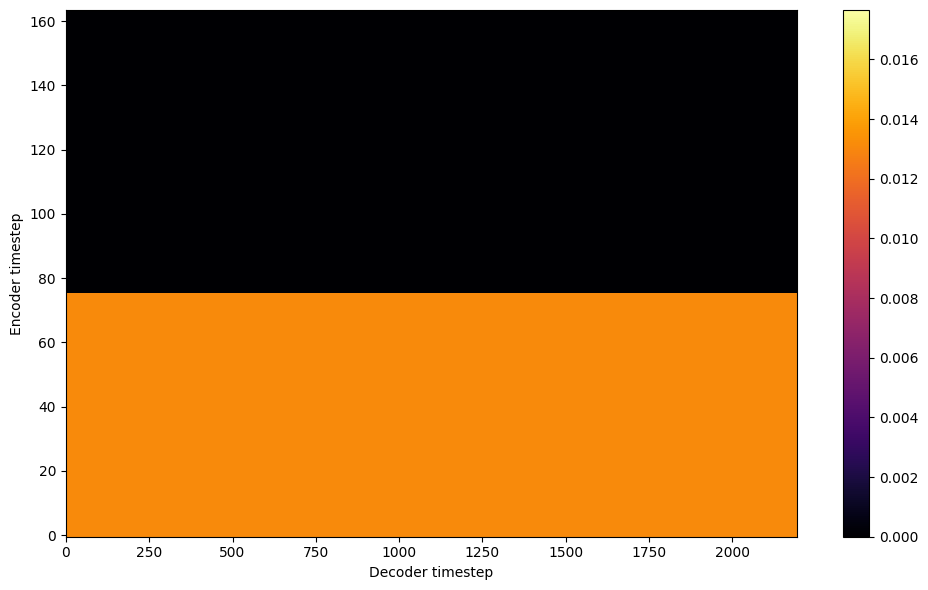


Starting Epoch: 71 Iteration: 355


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 71 Validation loss 360:  8.558690  Time: 0.8m LR: 0.030000


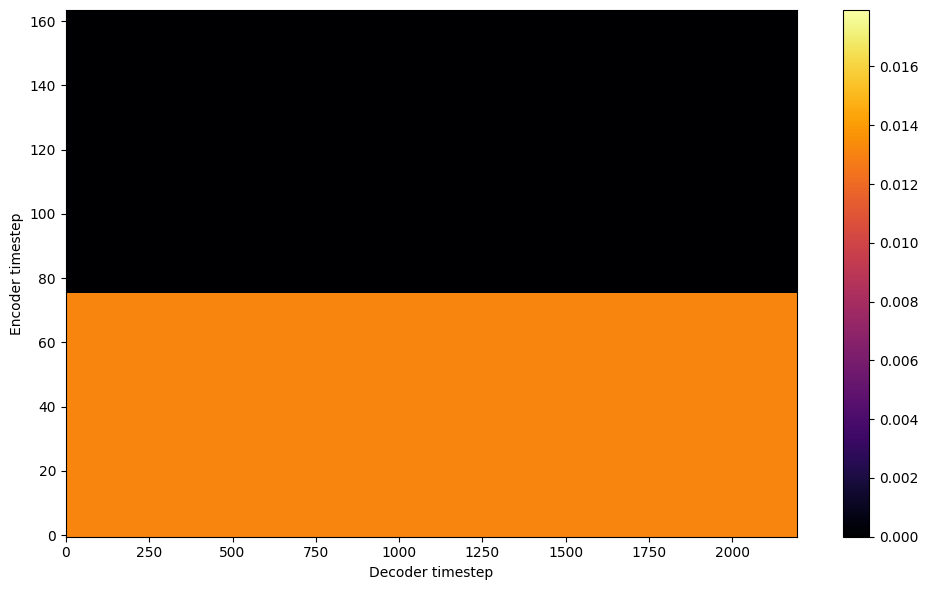


Starting Epoch: 72 Iteration: 360


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 72 Validation loss 365:  8.439385  Time: 0.8m LR: 0.030000


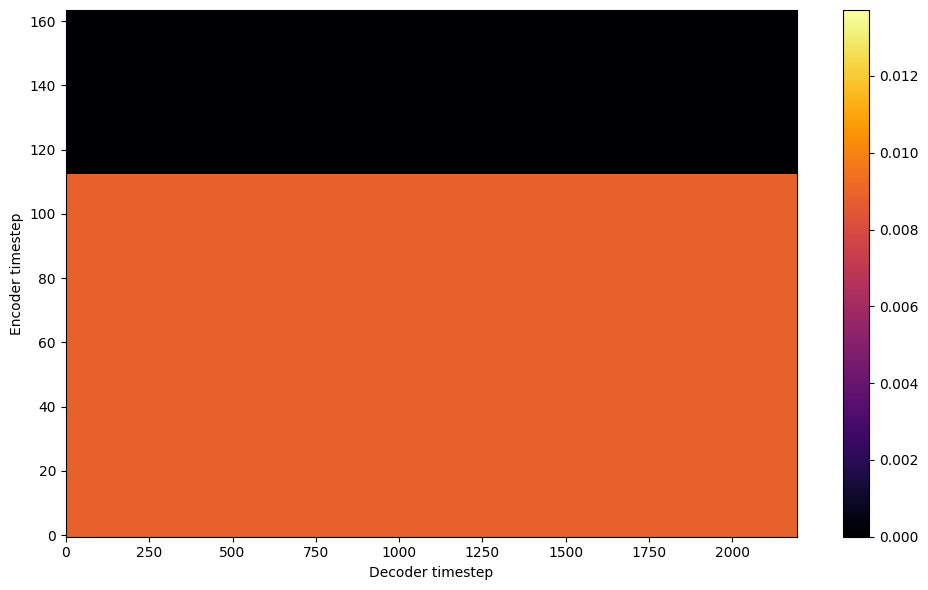


Starting Epoch: 73 Iteration: 365


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 73 Validation loss 370:  8.561414  Time: 0.7m LR: 0.030000


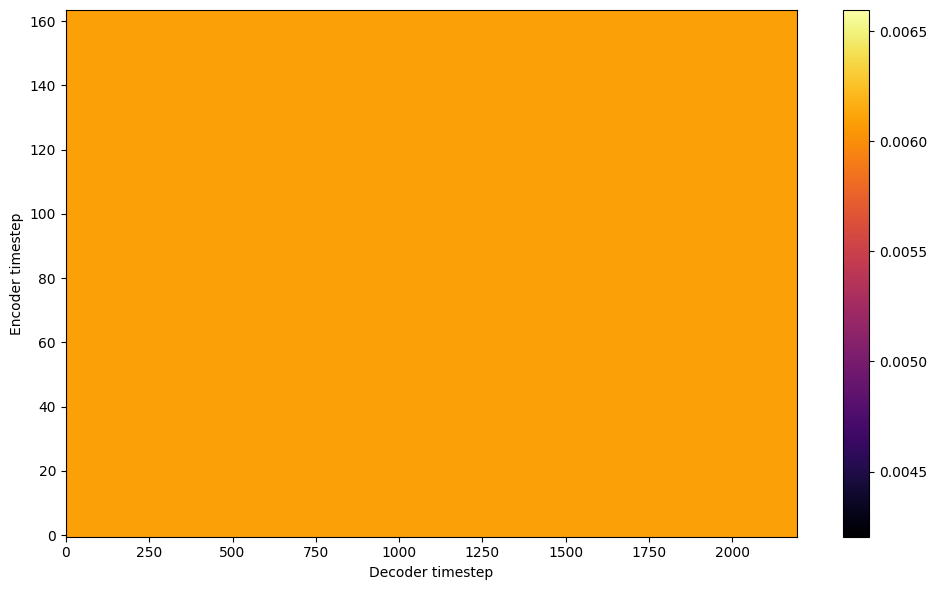


Starting Epoch: 74 Iteration: 370


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 74 Validation loss 375:  8.619127  Time: 0.8m LR: 0.030000


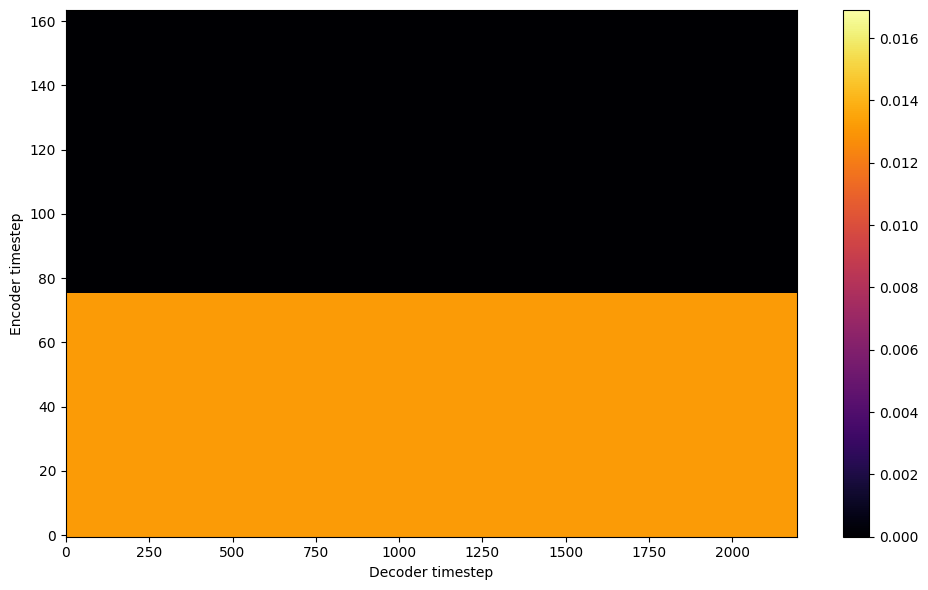


Starting Epoch: 75 Iteration: 375


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 75 Validation loss 380:  8.499111  Time: 0.7m LR: 0.030000


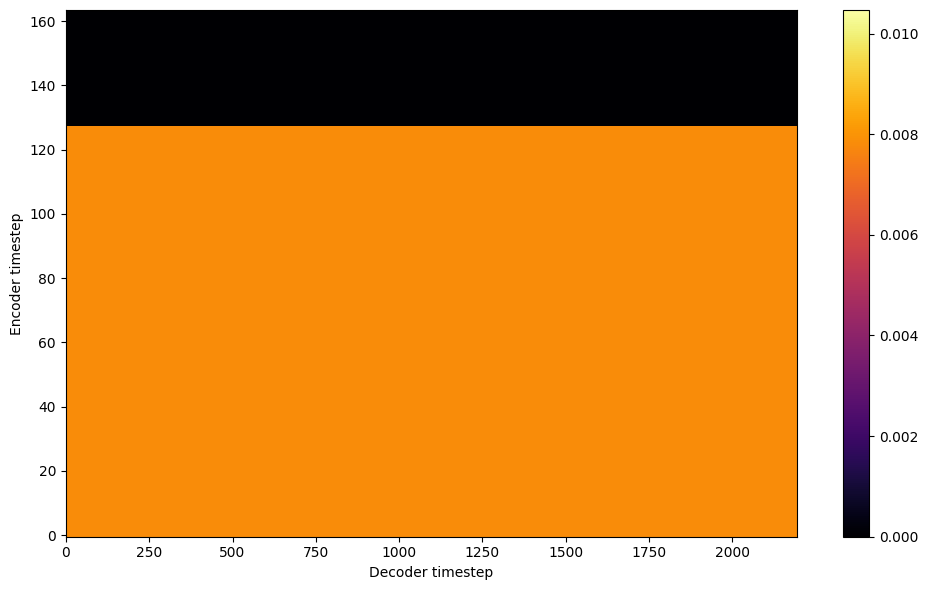


Starting Epoch: 76 Iteration: 380


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 76 Validation loss 385:  8.769909  Time: 0.7m LR: 0.030000


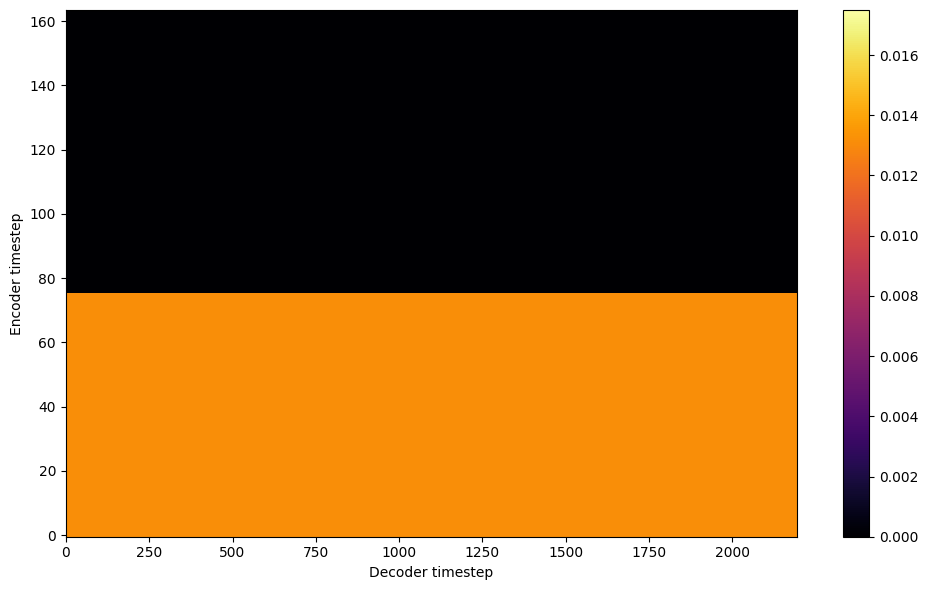


Starting Epoch: 77 Iteration: 385


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 77 Validation loss 390:  8.431588  Time: 0.7m LR: 0.030000


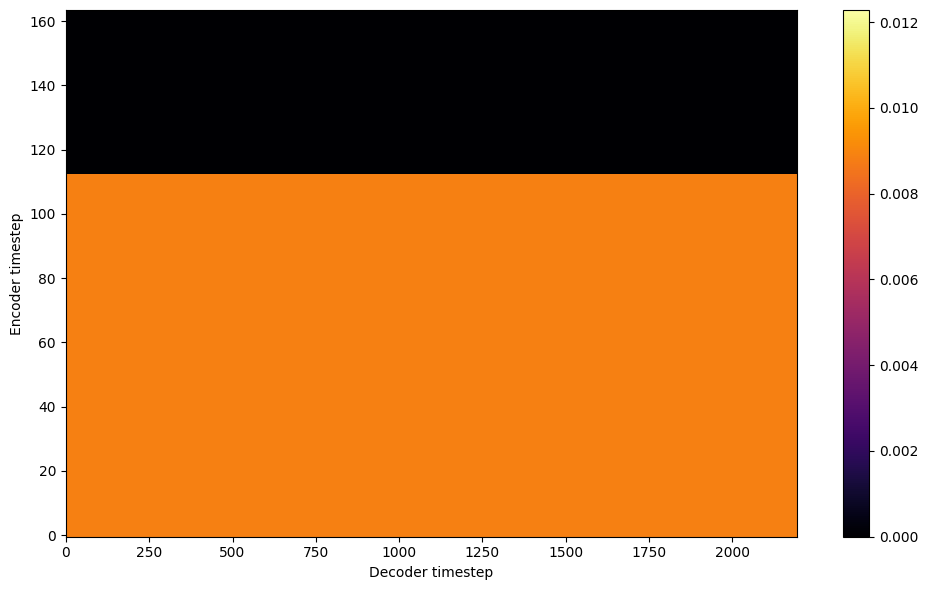


Starting Epoch: 78 Iteration: 390


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 78 Validation loss 395:  8.726479  Time: 0.8m LR: 0.030000


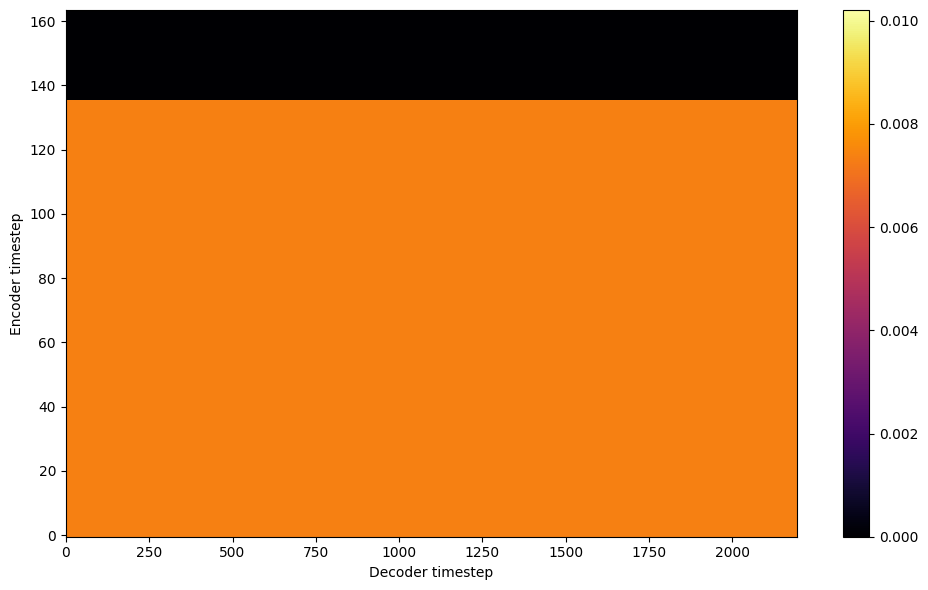


Starting Epoch: 79 Iteration: 395


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 79 Validation loss 400:  8.481750  Time: 0.7m LR: 0.030000


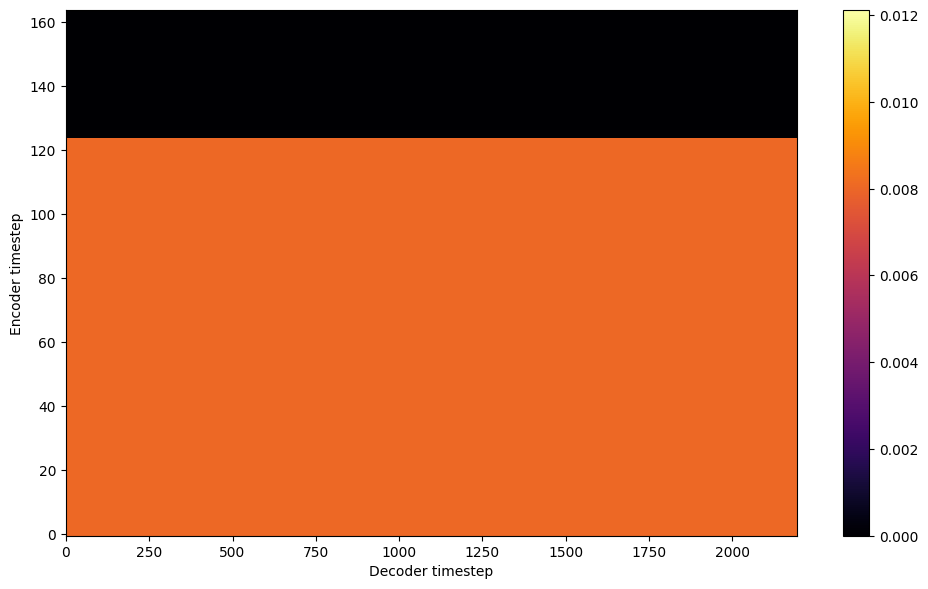

Saving model and optimizer state at iteration 400 to /content/drive/MyDrive/colab/outdir/modijii-40
Model Saved

Starting Epoch: 80 Iteration: 400


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 80 Validation loss 405:  8.712277  Time: 0.8m LR: 0.030000


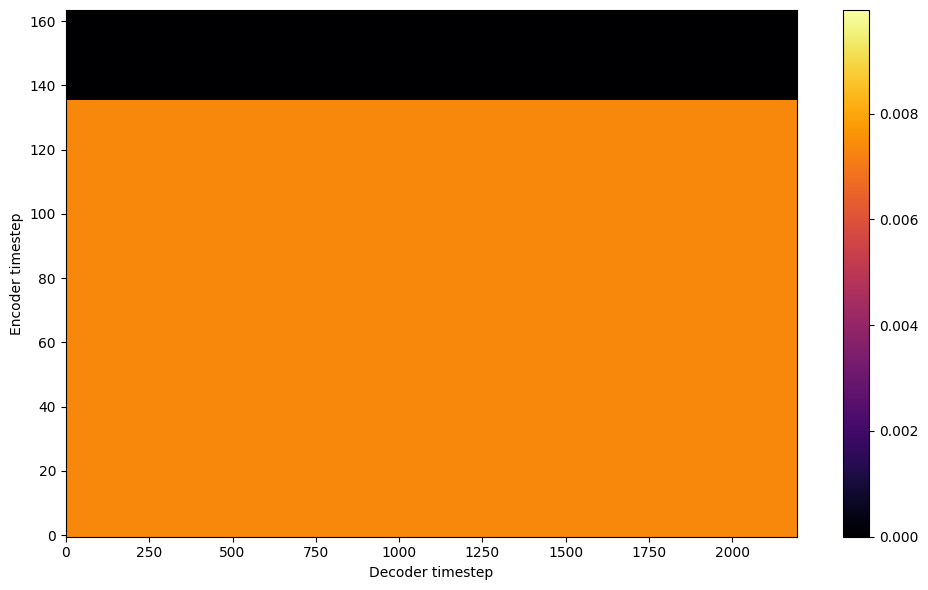


Starting Epoch: 81 Iteration: 405


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 81 Validation loss 410:  8.537973  Time: 0.7m LR: 0.030000


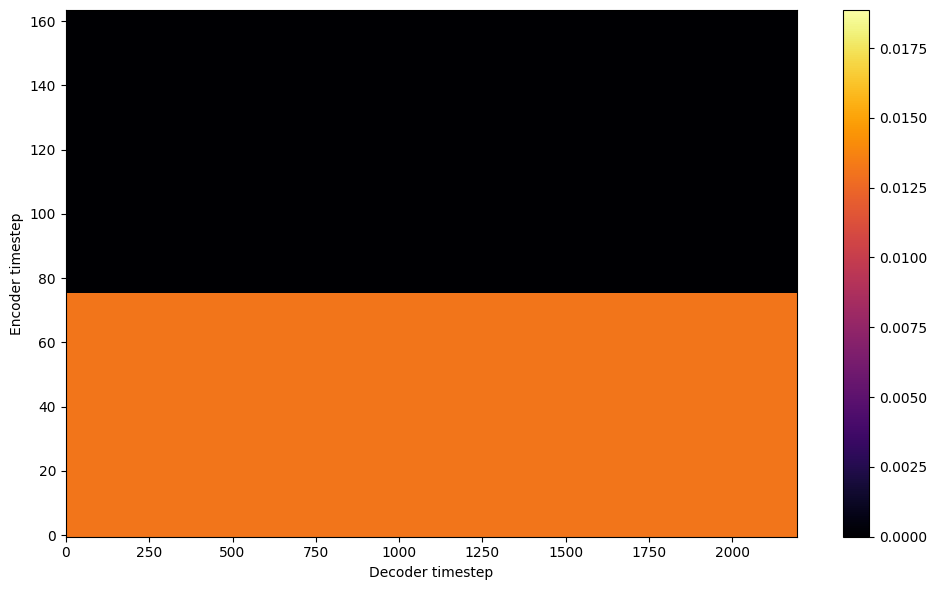


Starting Epoch: 82 Iteration: 410


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 82 Validation loss 415:  8.708622  Time: 0.7m LR: 0.030000


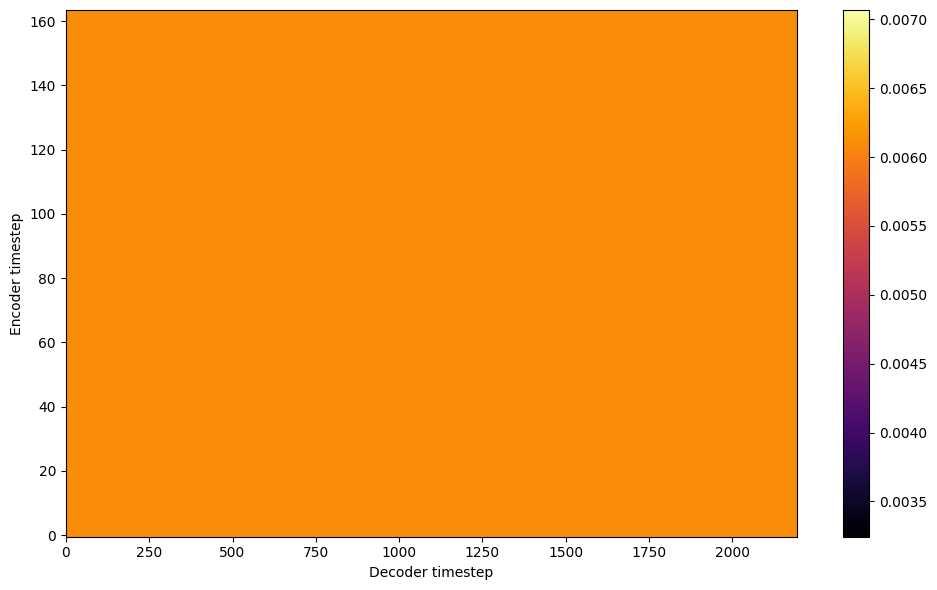


Starting Epoch: 83 Iteration: 415


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 83 Validation loss 420:  8.611243  Time: 0.7m LR: 0.030000


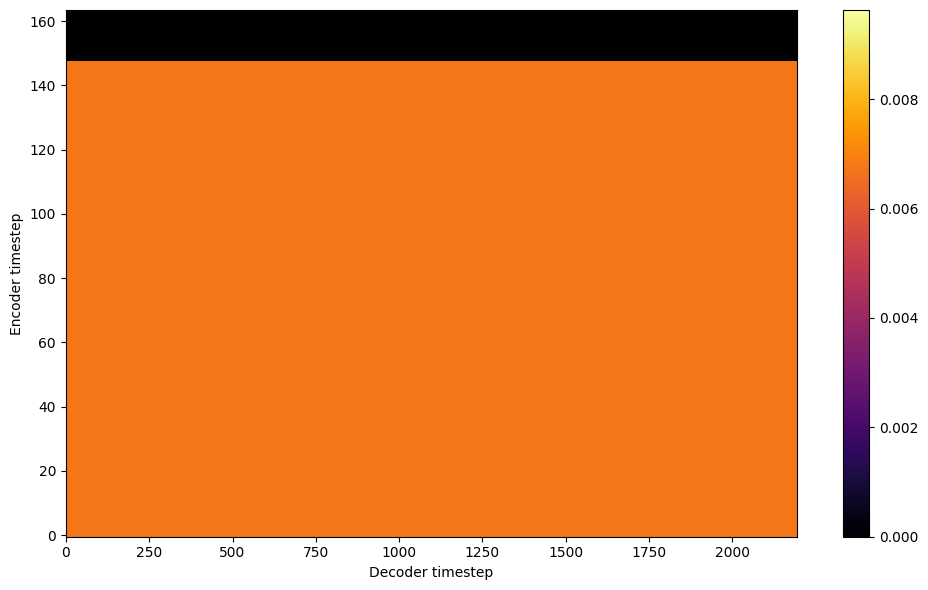


Starting Epoch: 84 Iteration: 420


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 84 Validation loss 425:  8.720566  Time: 0.7m LR: 0.030000


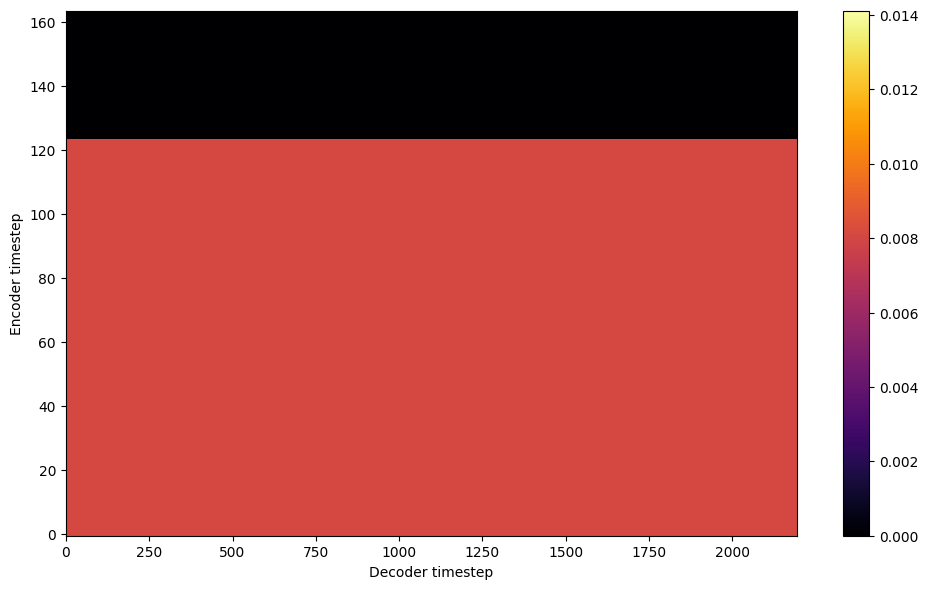


Starting Epoch: 85 Iteration: 425


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 85 Validation loss 430:  9.530889  Time: 0.8m LR: 0.030000


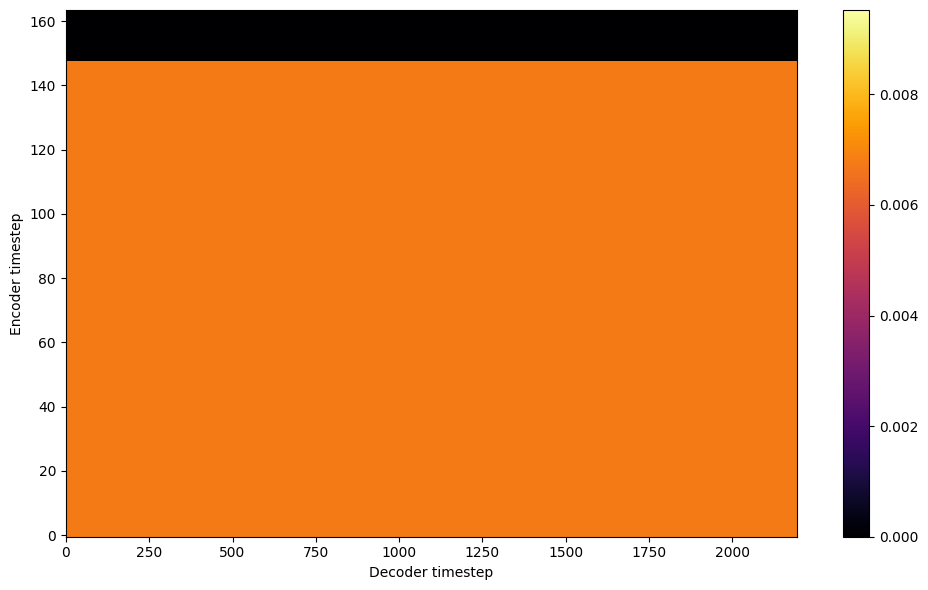


Starting Epoch: 86 Iteration: 430


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 86 Validation loss 435:  8.624545  Time: 0.7m LR: 0.030000


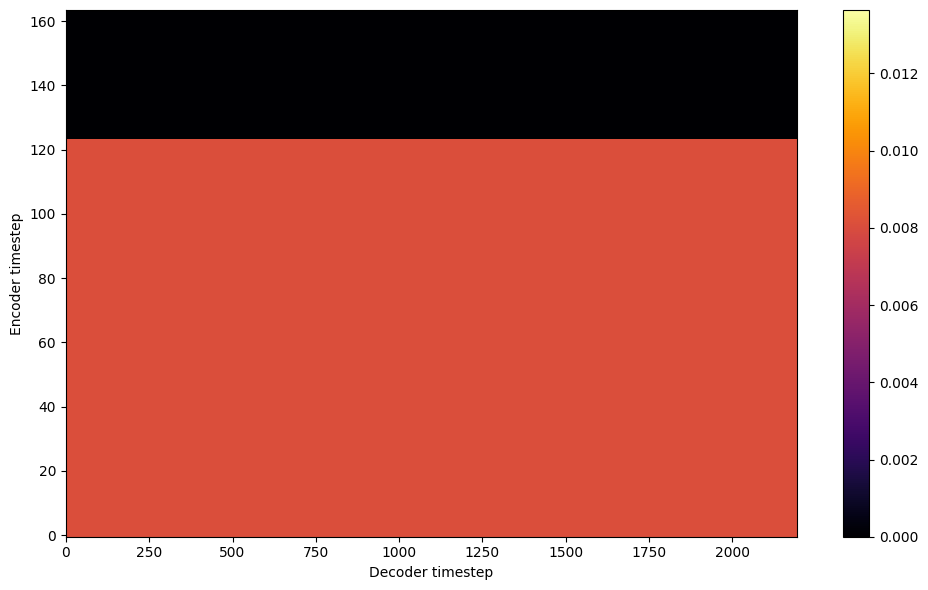


Starting Epoch: 87 Iteration: 435


  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:

#@markdown ___
#@markdown ### How often to save (number of epochs)
#@markdown `10` by default. Raise this if you're hitting a rate limit. If you're using a particularly large dataset, you might want to set this to `1` to prevent loss of progress.
save_interval =  10#@param {type: "integer"}
#
#@markdown ### How often to backup (number of epochs)
#@markdown `-1` (disabled) by default. This will save extra copies of your model every so often, so you always have something to revert to if you train the model for too long. This *will* chew through your Google Drive storage.
backup_interval =  -1#@param {type: "integer"}
#

print('FP16 Run:', hparams.fp16_run)
print('Dynamic Loss Scaling:', hparams.dynamic_loss_scaling)
print('Distributed Run:', hparams.distributed_run)
print('cuDNN Enabled:', hparams.cudnn_enabled)
print('cuDNN Benchmark:', hparams.cudnn_benchmark)
train(output_directory, log_directory, checkpoint_path,
      warm_start, n_gpus, rank, group_name, hparams, log_directory2,
      save_interval, backup_interval)

# **Final notes**

## A good training looks like this:

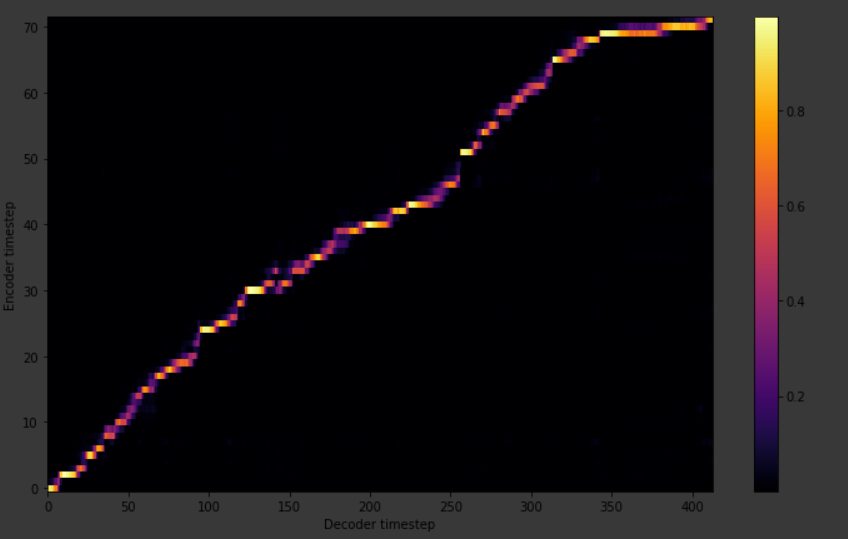